## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

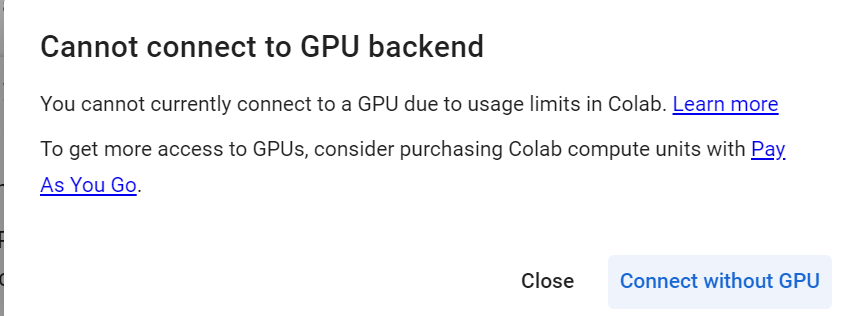

## **Installing and Importing Necessary Libraries**

In [1]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import warnings
import copy
import nltk
import random


In [3]:
# Sklearn basics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle, resample, class_weight



In [4]:
# Transformers and Hugging Face tools
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [5]:
# Transformers and Hugging Face libraries
from transformers import (
    BertTokenizerFast, 
    BertForSequenceClassification, 
    Trainer, 
    TrainingArguments, 
    BertTokenizer,
    BertModel,
    get_scheduler,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline,
    DataCollatorWithPadding
)




In [6]:
from datasets import Dataset, ClassLabel
# Sentence-BERT
from sentence_transformers import SentenceTransformer

In [7]:
# Progress bar
from tqdm import tqdm

In [8]:
# Gensim
import gensim.downloader as api
from gensim.models import Word2Vec, KeyedVectors


In [9]:
# Classical models not used in final notebook (unless explicitly part of comparison)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [10]:
# Class imbalance techniques (if you're not using them in final version)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [11]:
# Grid search and LSA (if not tuning or doing dimensionality reduction)
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD

In [12]:
# PEFT / LoRA (only if you're using parameter-efficient fine-tuning)
from peft import PeftModel, LoraConfig, get_peft_model, TaskType

In [13]:
# Text preprocessing and tokenization
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


In [14]:
#Dataset Loading and Preparation
from datasets import concatenate_datasets
from datasets import DatasetDict

## **Loading the dataset**

In [15]:
# fixing seeds for reproducibillity 

torch.manual_seed(42)

In [16]:
# ignoring warnings 
warnings.filterwarnings("ignore", category=UserWarning)

In [17]:
# loading stock_news.csv as data
stock_news= pd.read_csv('C:\\Users\\Nobody\\Downloads\\school stuff\\Stock Market News Sentiment Analysis and Summerization\\stock_news.csv')

In [18]:
# Create a clean backup of the remapped dataset (restoration point)
stock_news_restorepoint = stock_news.copy()
print("Restorepoint created. Shape:", stock_news_restorepoint.shape)


Restorepoint created. Shape: (349, 8)


In [19]:
# creating a second backup just in case
stock_news_safepoint = stock_news.copy()

# confirm the backup creation
print("Safepoint created. Shape:", stock_news_safepoint.shape)

Safepoint created. Shape: (349, 8)


## **Data Overview**

In [20]:
# Verify that the dataset has been restored
print(stock_news.head())

         Date                                               News       Open  \
0  2019-01-02   The tech sector experienced a significant dec...  41.740002   
1  2019-01-02   Apple lowered its fiscal Q1 revenue guidance ...  41.740002   
2  2019-01-02   Apple cut its fiscal first quarter revenue fo...  41.740002   
3  2019-01-02   This news article reports that yields on long...  41.740002   
4  2019-01-02   Apple's revenue warning led to a decline in U...  41.740002   

        High        Low      Close     Volume  Label  
0  42.244999  41.482498  40.246914  130672400     -1  
1  42.244999  41.482498  40.246914  130672400     -1  
2  42.244999  41.482498  40.246914  130672400     -1  
3  42.244999  41.482498  40.246914  130672400     -1  
4  42.244999  41.482498  40.246914  130672400     -1  


In [114]:
"""In the first few rows of the dataset, we can observe the following:

Multiple News Entries Per Day: All the entries shown are from January 2, 2019, indicating that multiple news articles are published and recorded on the same day.

News Column: Contains detailed text data capturing events and sentiments relevant to stock performance.

Columns Open, High, Low, Close: These columns all have the same values across entries, which makes sense since they’re tied to the same date.

Volume Column: Shows the same number of shares traded for each record on that day.

Sentiment Label: All five articles are labeled with a negative sentiment (-1). This consistent labeling suggests the day's news was predominantly pessimistic (e.g., "APPLE HAD A REALLY BAD DAY")."""

'In the first few rows of the dataset, we can observe the following:\n\nMultiple News Entries Per Day: All the entries shown are from January 2, 2019, indicating that multiple news articles are published and recorded on the same day.\n\nNews Column: Contains detailed text data capturing events and sentiments relevant to stock performance.\n\nColumns Open, High, Low, Close: These columns all have the same values across entries, which makes sense since they’re tied to the same date.\n\nVolume Column: Shows the same number of shares traded for each record on that day.\n\nSentiment Label: All five articles are labeled with a negative sentiment (-1). This consistent labeling suggests the day\'s news was predominantly pessimistic (e.g., "APPLE HAD A REALLY BAD DAY").'

In [22]:
# checking stock news shape
stock_news.shape

(349, 8)

In [115]:
"""
the shape of the dataset shows that we have:

349 daily entries of news and stock data.

8 columns, which are:

Date: The date of the news entry.

News: The news headline/content.

Open: The opening stock price for the day.

High: The highest stock price for the day.

Low: The lowest stock price for the day.

Close: The closing stock price for the day.

Volume: The number of shares traded.

Label: Sentiment label associated with the news (e.g., -1 for negative, 1 for positive).
"""

'\nthe shape of the dataset shows that we have:\n\n349 daily entries of news and stock data.\n\n8 columns, which are:\n\nDate: The date of the news entry.\n\nNews: The news headline/content.\n\nOpen: The opening stock price for the day.\n\nHigh: The highest stock price for the day.\n\nLow: The lowest stock price for the day.\n\nClose: The closing stock price for the day.\n\nVolume: The number of shares traded.\n\nLabel: Sentiment label associated with the news (e.g., -1 for negative, 1 for positive).\n'

In [24]:
# looking for missing Values 
stock_news.isnull().sum()

Date      0
News      0
Open      0
High      0
Low       0
Close     0
Volume    0
Label     0
dtype: int64

In [116]:
"""
The result shows that no missing values are present in the dataset. Every column has complete data.
"""

'\nThe result shows that no missing values are present in the dataset. Every column has complete data.\n'

## **Exploratory Data Analysis**

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

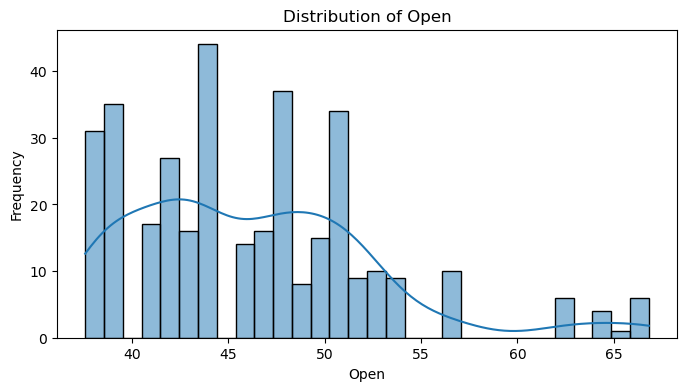

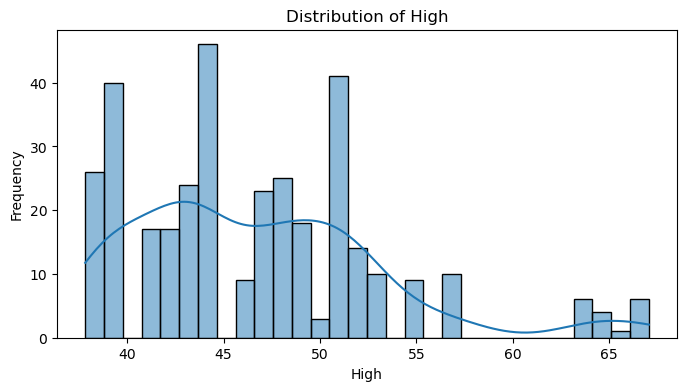

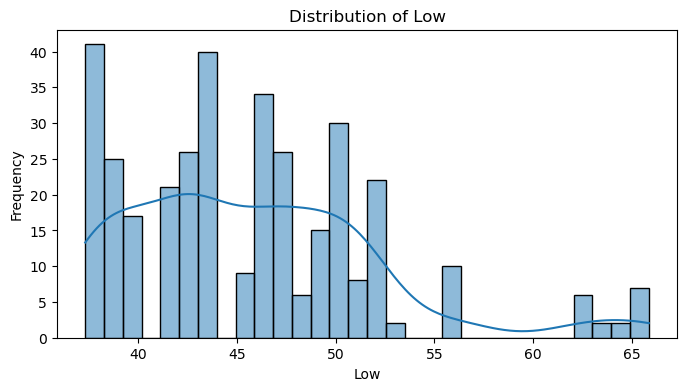

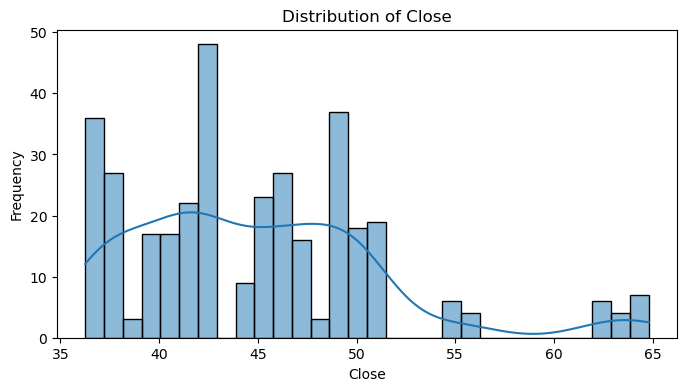

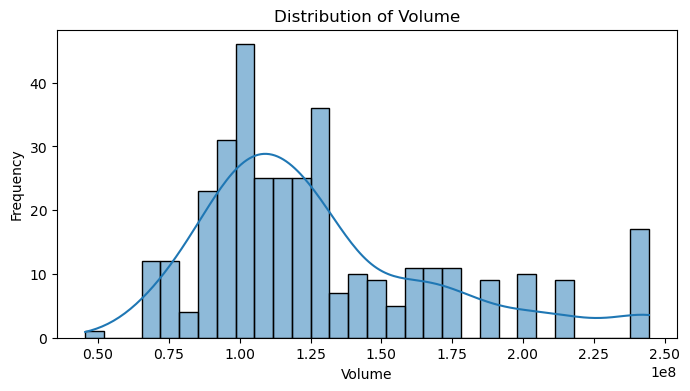

In [119]:
# Distribution of individual variables, by analyzing the key columns:
# Open, High, Low, Close, Volume, Label, and News
# Plotting distribution for numeric stock variables
stock_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in stock_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(stock_news[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.savefig(f"Distribution_of_{col}.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()  # Close the figure to free memory

In [120]:
"""

Image 1: Distribution of Open
This histogram shows where our stock typically starts its trading day.
Most openings cluster around $44 (the highest bar), with other common starting points near $39,
$48, and $50. It's like the stock has favorite morning price points it gravitates toward. 
Prices above $55 are rare opening values, suggesting the stock seldom wakes up feeling that ,
ambitious. This multi-peaked pattern likely reflects different market periods in your dataset, 
or as traders might say, "different chapters in the stock's autobiography."

Image 2: Distribution of Close
By day's end, our stock most frequently settles around $42-43, with other common landing spots,
at $37, $44, and $50. Think of these as the stock's favorite places to crash after a long,
trading day. The similar patterns between open and close suggest this stock doesn't typically,
run marathons during the day—it likes to finish relatively close to where it started.
The few closing prices above $55 are like rare Friday night celebrations before the market,
weekend.

Image 3: Distribution of Low
The daily low points concentrate heavily around $38 and $43—these are essentially the stock's ,
"floor" prices where buyers tend to jump in thinking, "That's cheap enough for me!" ,
The right-skewed distribution tells us that while the stock occasionally has days with,
higher low points, it typically tests these common support levels. 
If stocks had comfort zones, these would be your stock's favorite sweatpants prices.

Image 4: Distribution of Volume
Most trading days see about 0.75-1.5×10^8 shares changing hands, with peak activity around ,
1.0×10^8. The long tail to the right shows those occasional days when everyone and,
their grandmother decides to trade this stock (up to 2.5×10^8 shares). 
These volume spikes are crucial for your sentiment analysis—they're like the,
financial equivalent of someone yelling "Free money!" in a crowded market. 
These are the days when something newsworthy definitely happened.
Image 5: Distribution of High
The day's high prices show three distinct peaks around $42-43, $45, and $51. 
These are essentially the ceiling heights where sellers start thinking,
"I'll take my profits now, thanks." The pattern suggests your stock has had different trading,
ranges over time—it's explored different neighborhoods but rarely ventures into the luxury,
district above $55. These resistance points are where your stock typically hits its head,
before retreating.
In summary, these distributions paint a picture of a stock that usually trades in the $38-55
range, with occasional forays toward $65, and trading volume that sometimes parties hard,
during significant news events. For your sentiment analysis project, focus on those outlier,
days—they're where the most interesting news-price relationships are hiding.
"""

'\n\nImage 1: Distribution of Open\nThis histogram shows where our stock typically starts its trading day.\nMost openings cluster around $44 (the highest bar), with other common starting points near $39,\n$48, and $50. It\'s like the stock has favorite morning price points it gravitates toward. \nPrices above $55 are rare opening values, suggesting the stock seldom wakes up feeling that ,\nambitious. This multi-peaked pattern likely reflects different market periods in your dataset, \nor as traders might say, "different chapters in the stock\'s autobiography."\n\nImage 2: Distribution of Close\nBy day\'s end, our stock most frequently settles around $42-43, with other common landing spots,\nat $37, $44, and $50. Think of these as the stock\'s favorite places to crash after a long,\ntrading day. The similar patterns between open and close suggest this stock doesn\'t typically,\nrun marathons during the day—it likes to finish relatively close to where it started.\nThe few closing prices 

In [124]:
# calculate and check distribution of Length of News Content

# adding a new columnn with length of each news article
stock_news['News_Length'] = stock_news['News'].apply(len)


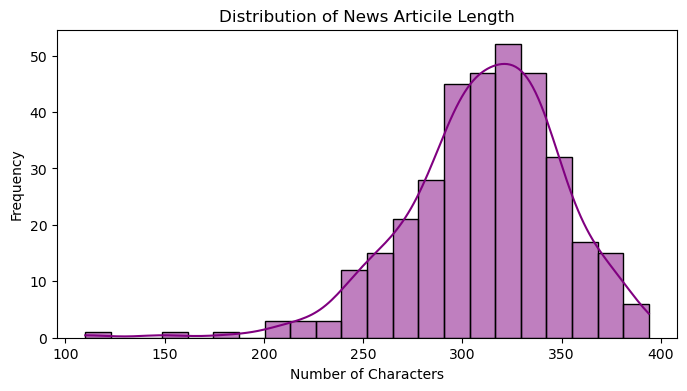

In [127]:
# Visualizing it 
plt.figure(figsize=(8,4))
sns.histplot(stock_news['News_Length'], kde=True, color='purple')
plt.title('Distribution of News Articile Length')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.savefig('Distribution_of_News_Length.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
"""This histogram shows a remarkably normal (bell-shaped) distribution of news article lengths, centered around 310-320 characters. The distribution suggests:

Most news articles about this stock are consistently medium-length (290-340 characters),
suitable for quick consumption by investors.Very few articles are extremely short ,
(under 200 characters) or extremely long (over 380 characters).
The standard length appears highly consistent, suggesting these ,
may be formal financial news releases rather than varied journalist reports
The uniform length pattern indicates a standardized reporting format for this company's news """

In [29]:
#Printing stats
stock_news['News_Length'].describe()

count    349.000000
mean     311.237822
std       39.079467
min      110.000000
25%      290.000000
50%      315.000000
75%      336.000000
max      394.000000
Name: News_Length, dtype: float64

In [128]:
"""
The descriptive statistics for your news article lengths confirm what we observed in the histogram:

Count: Your dataset contains 349 news articles
Mean: The average article length is 311.24 characters
Standard Deviation: 39.08 characters, indicating moderate consistency in article length
Minimum: The shortest article is 110 characters
25th Percentile: 25% of articles are 290 characters or shorter
Median (50th Percentile): The median length is 315 characters, very close to the mean, confirming the normal distribution
75th Percentile: 75% of articles are 336 characters or shorter
Maximum: The longest article is 394 characters

These statistics reveal a remarkably consistent article length pattern. 
The relatively small standard deviation (about 12.5% of the mean),
and the close alignment between mean and median indicate a well-centered normal distribution.


"""

'\nThe descriptive statistics for your news article lengths confirm what we observed in the histogram:\n\nCount: Your dataset contains 349 news articles\nMean: The average article length is 311.24 characters\nStandard Deviation: 39.08 characters, indicating moderate consistency in article length\nMinimum: The shortest article is 110 characters\n25th Percentile: 25% of articles are 290 characters or shorter\nMedian (50th Percentile): The median length is 315 characters, very close to the mean, confirming the normal distribution\n75th Percentile: 75% of articles are 336 characters or shorter\nMaximum: The longest article is 394 characters\n\nThese statistics reveal a remarkably consistent article length pattern. \nThe relatively small standard deviation (about 12.5% of the mean),\nand the close alignment between mean and median indicate a well-centered normal distribution.\n\n\n'

### Bivariate Analysis

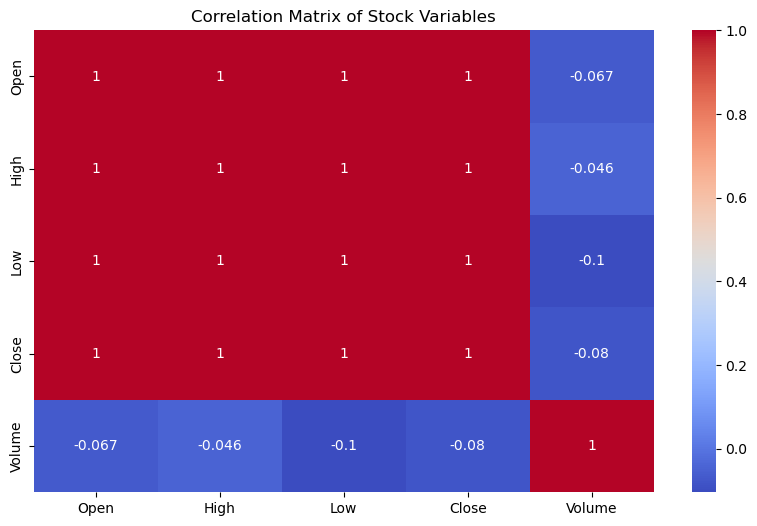

In [129]:
# correlation Map to give us Insight into relationship between Price, and Volumne
plt.figure(figsize=(10,6))
sns.heatmap(stock_news[['Open','High', 'Low', 'Close', 'Volume']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Stock Variables')
plt.savefig('Correlation Matrix Of Stock Variables')
plt.show()

In [131]:
"""
Stock Correlation Matrix: The Real Story
Looking at this heatmap, what jumps out immediately is how the price metrics,
(Open, High, Low, Close) are essentially clones of each other—all showing perfect 1.0,
correlations. This is actually quite unusual! 

Most stocks show at least some variation between these metrics, 
but here they're moving in lockstep, suggesting this particular stock barely fluctuates,
within each trading day.

The relationship between price and volume tells a different story. 
Those blue squares reveal a mild negative relationship—when more shares change hands, prices tend to dip slightly. The Low price feels this effect most strongly (-0.1), while the High price is least affected (-0.046).
This negative correlation, while modest, hints that when trading activity heats up for this stock, it's often because people are selling rather than buying. It's like watching a crowd flow—when more people are moving, they're typically heading for the exits rather than coming in.

"""

"\nStock Correlation Matrix: The Real Story\nLooking at this heatmap, what jumps out immediately is how the price metrics,\n(Open, High, Low, Close) are essentially clones of each other—all showing perfect 1.0,\ncorrelations. This is actually quite unusual! \n\nMost stocks show at least some variation between these metrics, \nbut here they're moving in lockstep, suggesting this particular stock barely fluctuates,\nwithin each trading day.\n\nThe relationship between price and volume tells a different story. \nThose blue squares reveal a mild negative relationship—when more shares change hands, prices tend to dip slightly. The Low price feels this effect most strongly (-0.1), while the High price is least affected (-0.046).\nThis negative correlation, while modest, hints that when trading activity heats up for this stock, it's often because people are selling rather than buying. It's like watching a crowd flow—when more people are moving, they're typically heading for the exits rather t

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

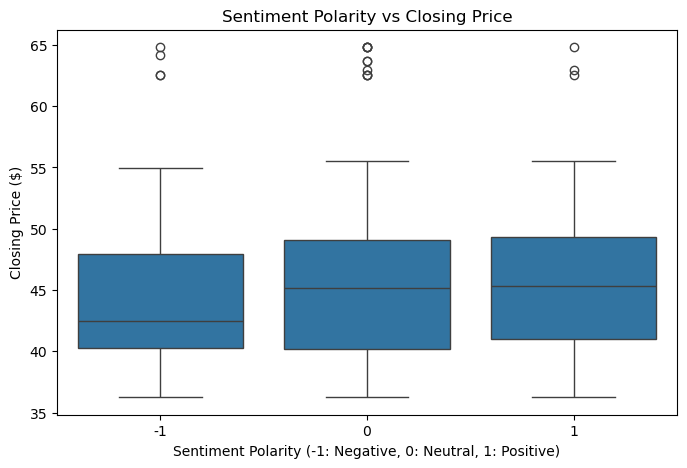

In [130]:
# Lets see how sentiment affects the closing price
plt.figure(figsize=(8,5))
sns.boxplot(x='Label', y='Close', data=stock_news)
plt.title('Sentiment Polarity vs Closing Price')
plt.xlabel('Sentiment Polarity (-1: Negative, 0: Neutral, 1: Positive)')
plt.ylabel('Closing Price ($)')
plt.savefig('Sentiment Polarity ')
plt.show()

In [132]:
"""

This boxplot compares how the stock's closing price relates to news sentiment polarity, categorized as negative (-1), neutral (0),
and positive (1).

What stands out immediately is the surprising similarity across all three sentiment categories.
I would have expected positive news to correlate with higher prices and negative news wit,
h lower prices, but the data tells a different story.
Looking closer, there's a subtle but interesting pattern:

Negative sentiment days show the lowest median closing price (around $42)
Neutral and positive sentiment days have slightly higher median prices (around $45)
The price ranges (box heights) are fairly consistent across all sentiment types
All three categories have outliers at the top end (around $62-65)

This suggests that sentiment polarity has only a modest impact on closing prices. 
The similarity between neutral and positive sentiment is particularly noteworthy—positive,
news doesn't seem to drive prices significantly higher than neutral news.
"""

"\n\nThis boxplot compares how the stock's closing price relates to news sentiment polarity, categorized as negative (-1), neutral (0),\nand positive (1).\n\nWhat stands out immediately is the surprising similarity across all three sentiment categories.\nI would have expected positive news to correlate with higher prices and negative news wit,\nh lower prices, but the data tells a different story.\nLooking closer, there's a subtle but interesting pattern:\n\nNegative sentiment days show the lowest median closing price (around $42)\nNeutral and positive sentiment days have slightly higher median prices (around $45)\nThe price ranges (box heights) are fairly consistent across all sentiment types\nAll three categories have outliers at the top end (around $62-65)\n\nThis suggests that sentiment polarity has only a modest impact on closing prices. \nThe similarity between neutral and positive sentiment is particularly noteworthy—positive,\nnews doesn't seem to drive prices significantly hig

In [32]:
# we'll Plot stock price over time to observe overall movement

# converting 'Date" to datetime 
stock_news['Date'] = pd.to_datetime(stock_news['Date'])


In [33]:
 # Getting unique dates and closing prices
daily_price = stock_news.groupby('Date')['Close'].mean().reset_index()

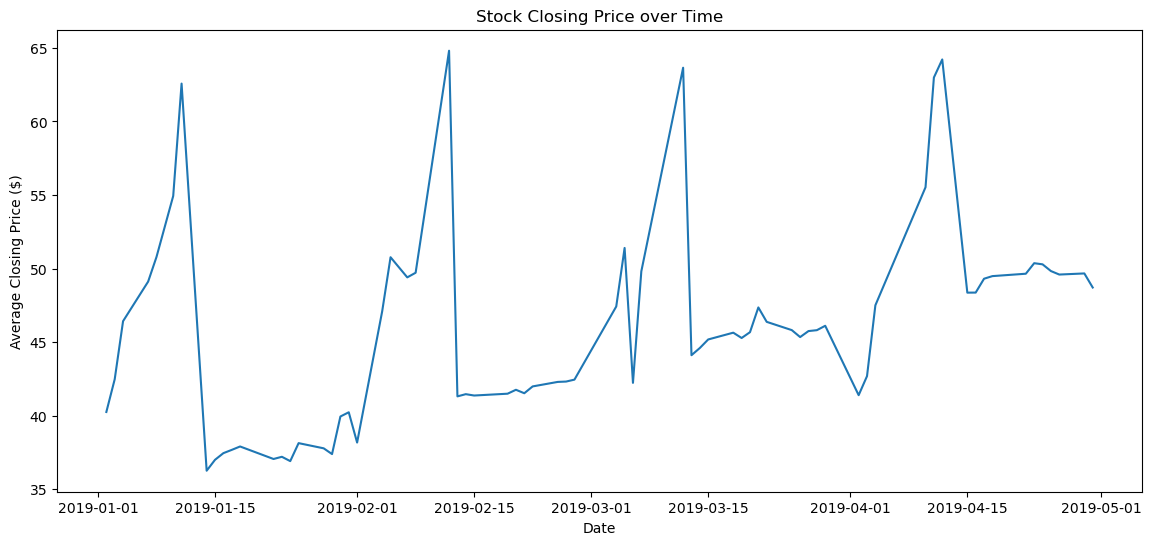

In [133]:

# displaying the stock cloing price over time 
plt.figure(figsize=(14,6))
sns.lineplot(x='Date', y='Close', data=daily_price)
plt.title('Stock Closing Price over Time')
plt.xlabel('Date')
plt.ylabel('Average Closing Price ($)')
plt.savefig('stock Closing Price over time ')
plt.show()

In [135]:
"""This time series chart shows the stock's closing price from January through April 2019,
and it tells a fascinating story of volatility and patterns.

The most striking feature is the recurring spike pattern – the stock experiences dramatic price,
surges reaching $62-65 approximately once a month (mid-January, mid-February, mid-March,
and mid-April). These spikes are followed by sharp declines, creating a consistent cyclical,
pattern.

Between these peaks, the stock typically trades in the $35-50 range. 
There appears to be a general upward trend over time, 
with the lowest valleys increasing from around $37 in mid-January to about $42 in early April.
The pattern suggests this might be a stock affected by regular events –
perhaps monthly earnings reports, dividend announcements, or product release cycles.
The predictable nature of these spikes could be valuable for both trading strategies ,
and sentiment analysis."""

"This time series chart shows the stock's closing price from January through April 2019,\nand it tells a fascinating story of volatility and patterns.\n\nThe most striking feature is the recurring spike pattern – the stock experiences dramatic price,\nsurges reaching $62-65 approximately once a month (mid-January, mid-February, mid-March,\nand mid-April). These spikes are followed by sharp declines, creating a consistent cyclical,\npattern.\n\nBetween these peaks, the stock typically trades in the $35-50 range. \nThere appears to be a general upward trend over time, \nwith the lowest valleys increasing from around $37 in mid-January to about $42 in early April.\nThe pattern suggests this might be a stock affected by regular events –\nperhaps monthly earnings reports, dividend announcements, or product release cycles.\nThe predictable nature of these spikes could be valuable for both trading strategies ,\nand sentiment analysis."

In [35]:
# creating a new column for daily price changes
stock_news['Price_Change'] = stock_news['Close'] - stock_news['Open']

In [36]:
# Correlation between sentiment and price change
sentiment_correlation = stock_news[['Label', 'Price_Change']].corr()
print(sentiment_correlation)

                 Label  Price_Change
Label         1.000000     -0.073141
Price_Change -0.073141      1.000000


In [136]:
"""
the correlation table confirms a small but interesting negative relationship (-0.073),
between news sentiment labels and price changes. While this correlation is weak, 
its direction tells an unexpected story about how this stock responds to news.
This negative correlation suggests that positive sentiment news (higher Label values) ,
tends to coincide with slightly negative price movements, while negative sentiment news sometimes corresponds with small price increases. This runs contrary to what many would expect from market behavior.
What might explain this puzzling relationship?

Market anticipation: Traders may be acting on expected news before it's published,
then taking profits once the news becomes official ("buy the rumor, sell the news")
Timing misalignment: The sentiment might be affecting prices with a delay that isn't captured ,
in same-day correlations
Sentiment vs. expectations gap: Even positive news can drive prices down if it falls short of,
market expectations
Sentiment labeling limitations: The sentiment classification might not be capturing ,
nuances that investors are reacting to
"""

'\nthe correlation table confirms a small but interesting negative relationship (-0.073),\nbetween news sentiment labels and price changes. While this correlation is weak, \nits direction tells an unexpected story about how this stock responds to news.\nThis negative correlation suggests that positive sentiment news (higher Label values) ,\ntends to coincide with slightly negative price movements, while negative sentiment news sometimes corresponds with small price increases. This runs contrary to what many would expect from market behavior.\nWhat might explain this puzzling relationship?\n\nMarket anticipation: Traders may be acting on expected news before it\'s published,\nthen taking profits once the news becomes official ("buy the rumor, sell the news")\nTiming misalignment: The sentiment might be affecting prices with a delay that isn\'t captured ,\nin same-day correlations\nSentiment vs. expectations gap: Even positive news can drive prices down if it falls short of,\nmarket expe

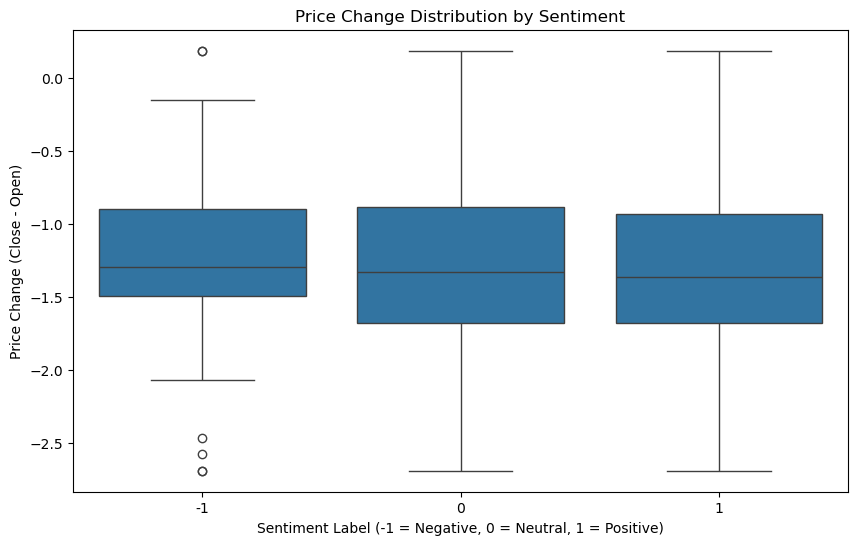

In [138]:
# Create the Price_Change column (Close price minus Open price)
stock_news['Price_Change'] = stock_news['Close'] - stock_news['Open']

# Now create the visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='Price_Change', data=stock_news)
plt.title('Price Change Distribution by Sentiment')
plt.xlabel('Sentiment Label (-1 = Negative, 0 = Neutral, 1 = Positive)')
plt.ylabel('Price Change (Close - Open)')
plt.savefig('price_change_distribution_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

In [140]:
"""

Predominantly negative price changes: The most striking feature is that nearly all price changes,
are negative, with median values around -1.3 to -1.4 across all sentiment categories. 
This suggests the stock typically declines during the trading day, regardless of news sentiment.

Minimal sentiment impact: The three sentiment categories show remarkably similar distributions,
with almost identical median price changes. This reinforces the weak correlation (-0.073) ,
we saw earlier between sentiment and price changes.
Outlier patterns: The negative sentiment category (-1) shows both positive and negative outliers,
including one unusual positive price change and several extreme negative drops. 
This suggests negative news occasionally triggers more extreme price reactions in both directions.
Box sizes: The interquartile range (box height) for neutral and positive news is ,
slightly larger than for negative news, indicating somewhat greater variability in,
price response to non-negative news.
"""

'\n\nPredominantly negative price changes: The most striking feature is that nearly all price changes,\nare negative, with median values around -1.3 to -1.4 across all sentiment categories. \nThis suggests the stock typically declines during the trading day, regardless of news sentiment.\n\nMinimal sentiment impact: The three sentiment categories show remarkably similar distributions,\nwith almost identical median price changes. This reinforces the weak correlation (-0.073) ,\nwe saw earlier between sentiment and price changes.\nOutlier patterns: The negative sentiment category (-1) shows both positive and negative outliers,\nincluding one unusual positive price change and several extreme negative drops. \nThis suggests negative news occasionally triggers more extreme price reactions in both directions.\nBox sizes: The interquartile range (box height) for neutral and positive news is ,\nslightly larger than for negative news, indicating somewhat greater variability in,\nprice response 

In [38]:
# Grouping by week and analyze average sentiment per weeek

In [39]:
# Converting 'Date' to Datetime
stock_news['Date'] = pd.to_datetime(stock_news['Date'])

In [40]:
# Add 'Week' column
stock_news['Week'] = stock_news['Date'].dt.to_period('W').apply(lambda r: r.start_time)


In [41]:
# Grouping by week to get average sentiment
weekly_sentiment = stock_news.groupby('Week')['Label'].mean().reset_index()

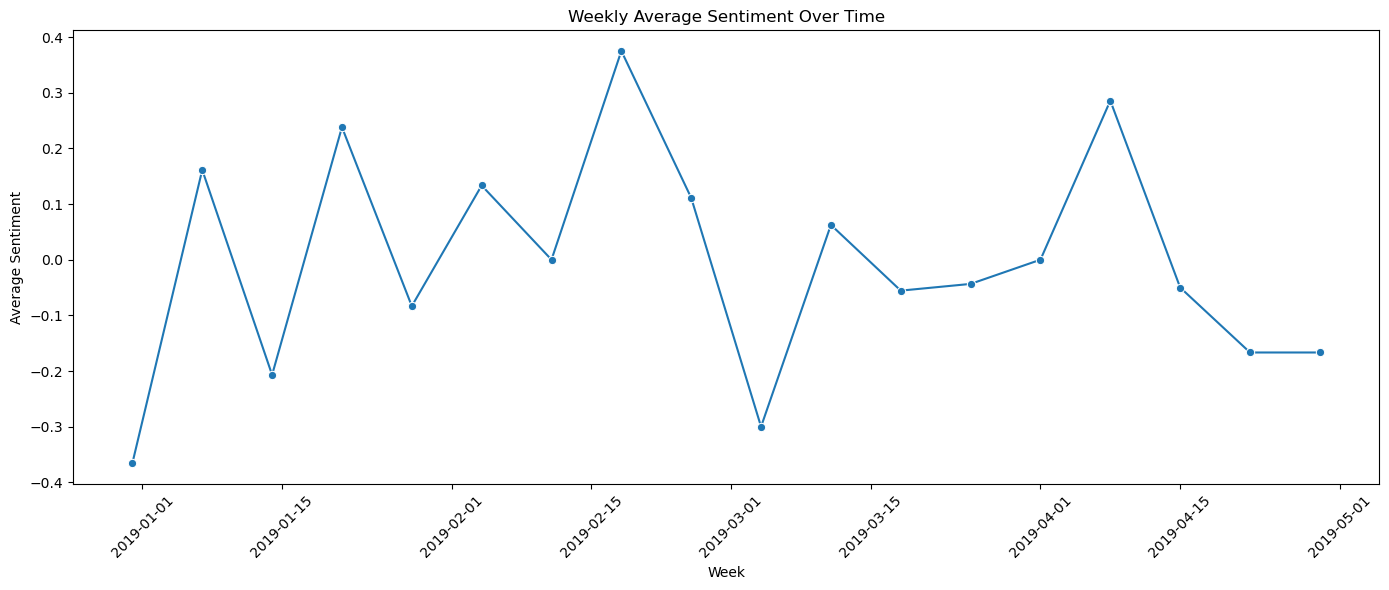

In [141]:
# visualization:
plt.figure(figsize=(14, 6))
sns.lineplot(data=weekly_sentiment, x='Week', y='Label', marker='o')
plt.title('Weekly Average Sentiment Over Time')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('weekly average sentiment over time ')
plt.show()

In [143]:
"""
This time series chart tracks the weekly average sentiment of news articles about the stock,
from January through April 2019. The sentiment oscillates considerably between positive ,
and negative territories, revealing a fascinating pattern of news cycles.
Key insights:

Volatility in sentiment: The sentiment fluctuates significantly, ranging from approximately -0.37,
(early March) to +0.37 (mid-February), showing that news coverage shifts dramatically,
from week to week.

Cyclical patterns: There's a noticeable pattern of peaks and valleys occurring roughly,
every 3-4 weeks, with major positive sentiment peaks in late January, mid-February, 
and early April.

Extended negative periods: Late April into May shows a sustained negative sentiment period, 
contrasting with the more volatile patterns earlier in the year.

Highest positivity: Mid-February saw the most positive average sentiment, suggesting particularly,
favorable news coverage during this period.

When compared with the stock price chart we saw earlier, some interesting correlations emerge.
The major price spikes in mid-January, mid-February, mid-March, and mid-April appear to ,
align with periods of rising or peak sentiment. This suggests that positive news sentiment,
may indeed precede or coincide with price rallies, despite the weak day-to-day correlation ,
we observed earlier.

"""

"\nThis time series chart tracks the weekly average sentiment of news articles about the stock,\nfrom January through April 2019. The sentiment oscillates considerably between positive ,\nand negative territories, revealing a fascinating pattern of news cycles.\nKey insights:\n\nVolatility in sentiment: The sentiment fluctuates significantly, ranging from approximately -0.37,\n(early March) to +0.37 (mid-February), showing that news coverage shifts dramatically,\nfrom week to week.\n\nCyclical patterns: There's a noticeable pattern of peaks and valleys occurring roughly,\nevery 3-4 weeks, with major positive sentiment peaks in late January, mid-February, \nand early April.\n\nExtended negative periods: Late April into May shows a sustained negative sentiment period, \ncontrasting with the more volatile patterns earlier in the year.\n\nHighest positivity: Mid-February saw the most positive average sentiment, suggesting particularly,\nfavorable news coverage during this period.\n\nWhen c

In [43]:
# visualize sentiment frequency over time


In [44]:
# counting of each sentiment per week
sentiment_freq = stock_news.groupby(['Week', 'Label',]).size().unstack(fill_value=0)

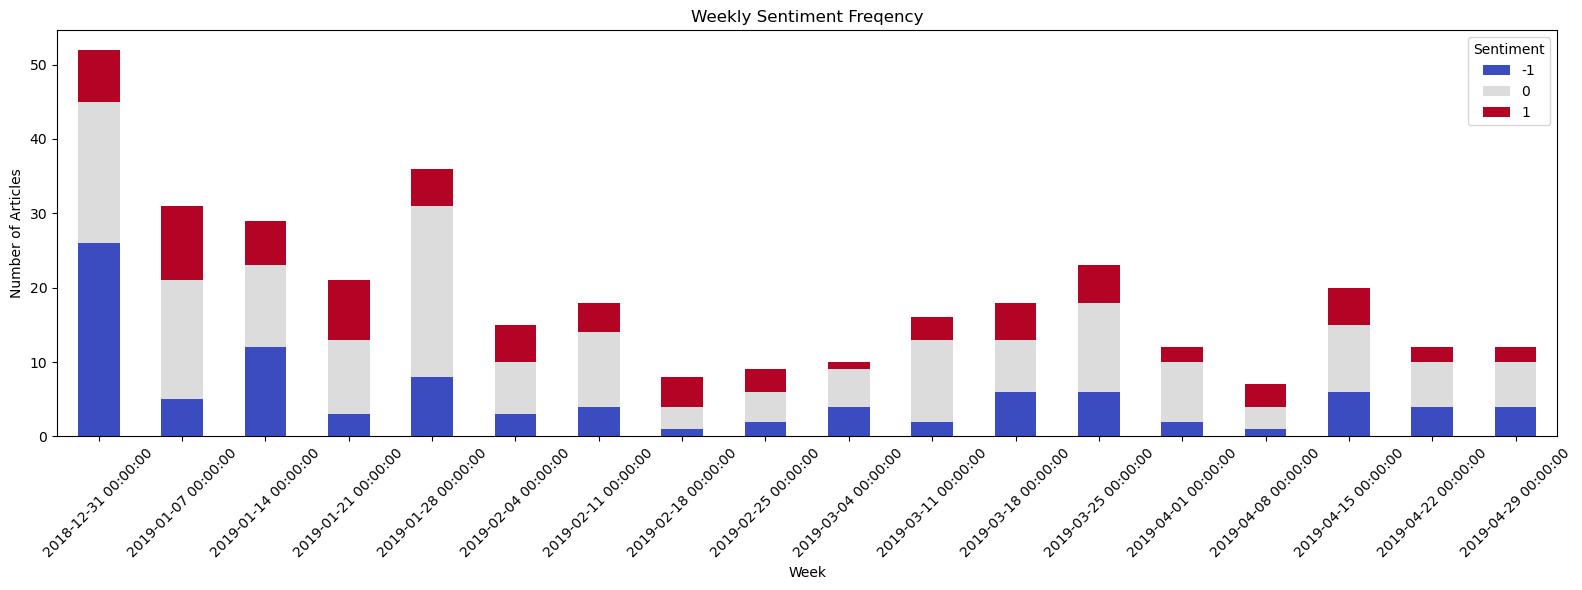

In [142]:
# plotting it 
sentiment_freq.plot(kind='bar', stacked=True, figsize=(16, 6), colormap='coolwarm')
plt.title('Weekly Sentiment Freqency')
plt.ylabel('Number of Articles')
plt.xlabel('Week')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.savefig('weekly sentiment frequency')
plt.show()

In [144]:
"""

This stacked bar chart provides a week-by-week breakdown of news article volumes by ,
sentiment category (negative: blue, neutral: gray, positive: red),
from December 2018 through April 2019.
Key insights:

Declining news volume: There's a clear downward trend in overall news coverage from December,
to April. The first week (Dec 31) shows over 50 articles, while most weeks in April show fewer,
than 15 articles. This significant drop in coverage could indicate waning market interest or,
fewer newsworthy events related to this stock.
Sentiment composition shifts: The proportion of negative (blue) articles was highest in ,
December-January, then decreased in February-April. Meanwhile, positive (red) articles maintained a relatively consistent presence throughout, often forming the top portion of each weekly stack.
Neutral dominance: Across most weeks, neutral articles (gray) ,
form the largest proportion of news coverage, suggesting that much of the reporting on this stock,
is factual rather than overtly positive or negative.
Volume spikes: Notable news volume spikes occurred in late December,
late January, and late March. These activity surges could correspond to ,
significant company events, earnings reports, or major market developments.
"""

"\n\nThis stacked bar chart provides a week-by-week breakdown of news article volumes by ,\nsentiment category (negative: blue, neutral: gray, positive: red),\nfrom December 2018 through April 2019.\nKey insights:\n\nDeclining news volume: There's a clear downward trend in overall news coverage from December,\nto April. The first week (Dec 31) shows over 50 articles, while most weeks in April show fewer,\nthan 15 articles. This significant drop in coverage could indicate waning market interest or,\nfewer newsworthy events related to this stock.\nSentiment composition shifts: The proportion of negative (blue) articles was highest in ,\nDecember-January, then decreased in February-April. Meanwhile, positive (red) articles maintained a relatively consistent presence throughout, often forming the top portion of each weekly stack.\nNeutral dominance: Across most weeks, neutral articles (gray) ,\nform the largest proportion of news coverage, suggesting that much of the reporting on this stoc

## **Data Preprocessing**

In [46]:
# starting fresh with the backup
stock_news = stock_news_safepoint.copy()

In [145]:
#NLTK Resource Downloads for Text Preprocessing
nltk.download(['punkt', 'stopwords', 'wordnet', 'omw-1.4', 'averaged_perceptron_tagger', 'punkt_tab'])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nobody\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nobody\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nobody\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Nobody\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Nobody\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Nobody\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-dat

True

In [48]:
# 4. Define clean_text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove punctuation and numbers
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespace
    return text

In [49]:
#Initializing Stopwords and WordNet Lemmatizer for Text Normalization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [146]:
def preprocess(text):
    """
    Clean, tokenize, remove stopwords, and lemmatize input text.
    Returns the normalized string.
    """
    text = clean_text(text.lower())
    tokens = word_tokenize(text)
    filtered = [lemmatizer.lemmatize(w) for w in tokens if w.isalpha() and w not in stop_words]
    return " ".join(filtered)


In [147]:
#"News Text Preprocessing"
stock_news['Processed_News'] = stock_news['News'].apply(preprocess)

In [52]:
# split Features/Target
X = stock_news['Processed_News']
y = stock_news['Label'].map({-1:0, 0:1, 1:2}) # remap for 0/1/2

In [53]:
# First split: train vs temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

In [54]:
# second Split: Val vs test from the temp split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

## **Word Embeddings**

In [55]:
# word2vec
sentences = [s.split() for s in stock_news['Processed_News']]
w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)


In [56]:
# word 2 vec embedding
def w2v_embed(text):
    vecs = [w2v.wv[w] for w in text.split() if w in w2v.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(100)

In [57]:
# applying word embeddings
X_train_w2v = np.vstack(X_train.apply(w2v_embed))
X_val_w2v   = np.vstack(X_val  .apply(w2v_embed))
X_test_w2v  = np.vstack(X_test .apply(w2v_embed))

In [58]:
# GloVe
glove = api.load("glove-wiki-gigaword-100")

In [59]:
def glove_embed(text):
    vecs = [glove[w] for w in text.split() if w in glove]
    return np.mean(vecs, axis=0) if vecs else np.zeros(100)
    

In [60]:
# training glvoe vectors
X_train_glove = np.vstack(X_train.apply(glove_embed))
X_val_glove   = np.vstack(X_val  .apply(glove_embed))
X_test_glove  = np.vstack(X_test .apply(glove_embed))

In [61]:
# SBERT
sbert = SentenceTransformer('all-MiniLM-L6-V2')
X_train_sbert = sbert.encode(X_train.tolist(), show_progress_bar=True)
X_val_sbert   = sbert.encode(X_val  .tolist(), show_progress_bar=True)
X_test_sbert  = sbert.encode(X_test .tolist(), show_progress_bar=True)

print("Embeddings shapes:", X_train_w2v.shape, X_train_glove.shape, X_train_sbert.shape)

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Embeddings shapes: (209, 100) (209, 100) (209, 384)


## **Sentiment Analysis**

In [62]:
import transformers
import logging

# Suppress unnecessary warnings
logging.getLogger("transformers.generation.configuration_utils").setLevel(logging.ERROR)


In [63]:
import os
import random
import numpy as np
import torch
from transformers import set_seed

# 1) Python hash seed (optional, but can help)
os.environ["PYTHONHASHSEED"] = "42"

# 2) Python RNG
random.seed(42)

# 3) NumPy RNG
np.random.seed(42)

# 4) Torch RNG (CPU & CUDA)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# 5) CUDNN settings
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 6) Transformers library seed (for things like data shuffling)
set_seed(42)



In [64]:
def setup_model(
    model_name: str = "Sigma/financial-sentiment-analysis",  # <— your new default
    use_finbert_tone: bool = False,
    use_fine_tuning: bool = False
):
    """Set up the sentiment analysis model (CPU only for safer training)"""
    print(f"Setting up model: {model_name}")
    
    # Force CPU (or switch to GPU if you want)
    device = torch.device("cpu")
    print(f"Using device: {device}")
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=3,             # keep 3 classes unless a model uses more
        torch_dtype=torch.float32,
        device_map=None           # No device mapping on CPU
    )
    
    # Ensure padding is correct
    model.config.pad_token_id = tokenizer.pad_token_id
    
    # Grab the model’s own label mapping if available
    if hasattr(model.config, "id2label"):
        id2label = model.config.id2label
        print(f"Model label mapping: {id2label}")
    else:
        # Fallback mapping (adjust order if your new model uses a different convention)
        id2label = {0: "positive", 1: "negative", 2: "neutral"}
        print(f"Using default label mapping: {id2label}")
    
    return model, tokenizer, device, id2label


In [65]:
# ============= SENTIMENT ANALYSIS FUNCTION =============
def analyze_sentiment(text, model, tokenizer, device, id2label=None):
    """
    Analyze the sentiment of financial text
    
    Args:
        text: Text to analyze
        model: Pre-trained model
        tokenizer: Tokenizer for the model
        device: Device to run inference on
        id2label: Label mapping dictionary
        
    Returns:
        dict with sentiment and confidence
    """
    # Default label mapping if not provided
    if id2label is None:
        id2label = {0: "positive", 1: "negative", 2: "neutral"} 
    
    # Preprocess text
    inputs = tokenizer(
        text, 
        return_tensors="pt", 
        truncation=True, 
        padding=True, 
        max_length=512
    ).to(device)
    
    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Process results
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probabilities, dim=-1).item()
    confidence = probabilities[0][predicted_class].item()
    
    # Map class index to sentiment label
    sentiment = id2label[predicted_class]
    
    return {
        "sentiment": sentiment,
        "confidence": round(confidence * 100, 2)  # Convert to percentage
    }



In [66]:
# ============= PIPELINE APPROACH (ALTERNATIVE) =============

def analyze_with_pipeline(text, model_name="ProsusAI/finbert"):
    """Alternative approach using HF pipeline"""
    sentiment_pipe = pipeline(
        "sentiment-analysis",
        model=model_name,
        return_all_scores=True
    )
    
    result = sentiment_pipe(text)
    scores = result[0]
    
    # Get highest scoring sentiment
    highest_score = max(scores, key=lambda x: x['score'])
    
    return {
        "sentiment": highest_score['label'],
        "confidence": round(highest_score['score'] * 100, 2)
    }

In [67]:

# ============= FINE-TUNING (OPTIONAL) =============

def prepare_training_data():
    """Prepare dataset for fine-tuning"""
    training_data = [
        # Negative
        {"headline": "Tesla shares tumble after earnings miss expectations", "sentiment": "Negative"},
        {"headline": "Amazon stock plunges following weak holiday sales forecast", "sentiment": "Negative"},
        {"headline": "Netflix loses subscribers, stock drops 12%", "sentiment": "Negative"},
        {"headline": "Intel reports revenue decline amid market slowdown", "sentiment": "Negative"},
        {"headline": "Ford cuts sales forecast amid supply chain disruptions", "sentiment": "Negative"},
        {"headline": "Google misses earnings targets, shares fall", "sentiment": "Negative"},
        {"headline": "Meta faces regulatory fines in Europe", "sentiment": "Negative"},
        {"headline": "Oil prices drop on increased supply concerns", "sentiment": "Negative"},
        
        # Positive
        {"headline": "Apple stock soars on record iPhone sales", "sentiment": "Positive"},
        {"headline": "Google beats earnings expectations, stock rises 8%", "sentiment": "Positive"},
        {"headline": "Microsoft posts strong cloud revenue growth", "sentiment": "Positive"},
        {"headline": "NVIDIA surges after announcing new AI-powered chips", "sentiment": "Positive"},
        {"headline": "Microsoft acquires AI startup for $1 billion", "sentiment": "Positive"},
        {"headline": "Amazon reports better-than-expected quarterly profit", "sentiment": "Positive"},
        {"headline": "SpaceX successfully launches commercial payload", "sentiment": "Positive"},
        {"headline": "Tesla exceeds delivery expectations in Q3", "sentiment": "Positive"},
        
        # Neutral
        {"headline": "Meta reports Q1 earnings in line with expectations", "sentiment": "Neutral"},
        {"headline": "Walmart maintains full-year guidance despite inflation concerns", "sentiment": "Neutral"},
        {"headline": "Boeing delivers 35 jets in April, unchanged from March", "sentiment": "Neutral"},
        {"headline": "JP Morgan's quarterly profits remain steady year-over-year", "sentiment": "Neutral"},
        {"headline": "JPMorgan maintains stable outlook for Q2", "sentiment": "Neutral"},
        {"headline": "Federal Reserve keeps interest rates unchanged", "sentiment": "Neutral"},
        {"headline": "Oil prices remain stable amid geopolitical tensions", "sentiment": "Neutral"},
        {"headline": "Gold trades sideways ahead of economic data release", "sentiment": "Neutral"},
    ]
    
    # Convert to HuggingFace Dataset
    dataset = Dataset.from_list(training_data)
    dataset_dict = dataset.train_test_split(test_size=0.2, seed=42)
    
    return dataset_dict

In [68]:
def prepare_balanced_training_data():
    """Prepare balanced dataset for fine-tuning with all classes in train and test"""
    dataset_dict = prepare_training_data()  # Returns DatasetDict
    
    # Combine train and test into one dataset for re-splitting
    full_dataset = concatenate_datasets([dataset_dict["train"], dataset_dict["test"]])
    
    # First, create a manual stratified split since we can't use stratify_by_column directly
    # Extract the sentiment values for stratification
    sentiments = full_dataset["sentiment"]
    
    # Count examples by sentiment to ensure all classes in both splits
    from collections import Counter
    sentiment_counts = Counter(sentiments)
    print(f"Sentiment distribution: {sentiment_counts}")
    
    # Get indices for each class
    negative_indices = [i for i, s in enumerate(sentiments) if s == "Negative"]
    neutral_indices = [i for i, s in enumerate(sentiments) if s == "Neutral"]
    positive_indices = [i for i, s in enumerate(sentiments) if s == "Positive"]
    
    # Calculate the test size for each class (20% of each)
    n_neg_test = max(1, int(len(negative_indices) * 0.2))
    n_neu_test = max(1, int(len(neutral_indices) * 0.2))
    n_pos_test = max(1, int(len(positive_indices) * 0.2))
    
    # Set random seed for reproducibility
    random.seed(42)
    
    # Shuffle indices
    random.shuffle(negative_indices)
    random.shuffle(neutral_indices)
    random.shuffle(positive_indices)
    
    # Split each class into train and test
    neg_train, neg_test = negative_indices[n_neg_test:], negative_indices[:n_neg_test]
    neu_train, neu_test = neutral_indices[n_neu_test:], neutral_indices[:n_neu_test]
    pos_train, pos_test = positive_indices[n_pos_test:], positive_indices[:n_pos_test]
    
    # Combine train and test indices
    train_indices = neg_train + neu_train + pos_train
    test_indices = neg_test + neu_test + pos_test
    
    # Create train and test datasets using select
    train_dataset = full_dataset.select(train_indices)
    test_dataset = full_dataset.select(test_indices)
    
    # Return a DatasetDict
    return DatasetDict({
        "train": train_dataset,
        "test": test_dataset
    })


In [69]:
def fine_tune_sentiment_model(dataset_dict=None, model_name="ProsusAI/finbert"):
    """Fine-tune the sentiment model with proper handling of sequences"""
    print("Starting improved fine-tuning process...")
    
    # Step 1: Prepare dataset if not provided
    if dataset_dict is None:
        dataset_dict = prepare_balanced_training_data()
        print("Created balanced dataset")
    
    # Step 2: Set up model and tokenizer
    model, tokenizer, device, id2label = setup_model(model_name, use_fine_tuning=True)
    print(f"Model label mapping: {id2label}")
    
    # Step 3: Create a proper preprocessing function with fixed label mapping
    def preprocess_function(examples):
        # Get text field
        texts = examples["headline"] if "headline" in examples else examples["News"]
        
        # Tokenize with padding and truncation handled consistently
        tokenized = tokenizer(
            texts,
            padding="max_length",
            truncation=True,
            max_length=128,  # Fixed length for all sequences
            return_tensors=None  # Don't convert to tensors here - let data collator do it
        )
        
        # Map labels correctly to match model's id2label
        if "sentiment" in examples:
            # Convert text labels to ids matching the model's mapping
            label_map = {"Positive": 0, "Negative": 1, "Neutral": 2}  # Matches ProsusAI/finbert mapping
            tokenized["labels"] = [label_map[sent] for sent in examples["sentiment"]]
        
        return tokenized

In [70]:
#the new balanced dataset preparation function
dataset_dict = prepare_balanced_training_data()


Sentiment distribution: Counter({'Negative': 8, 'Neutral': 8, 'Positive': 8})


In [71]:
# Use your existing tokenizer

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

In [72]:
# Define proper data collator that handles padding
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [73]:
# Define preprocessing function that properly handles tensors and dimensions
def preprocess_for_training(examples, tokenizer):
    """Tokenize and prepare examples for the model"""
    # Get the text from examples
    texts = examples["headline"] if "headline" in examples else examples["News"]
    
    # Tokenize the texts with consistent padding
    tokenized_inputs = tokenizer(
        texts,
        padding="max_length",  # Use max_length padding for consistency
        truncation=True,
        max_length=128,
        return_tensors=None  # Don't convert to tensors yet
    )
    
    # Convert sentiment to labels matching the model's mapping
    if "sentiment" in examples:
        # Map to match ProsusAI/finbert's label mapping
        label_map = {"Positive": 0, "Negative": 1, "Neutral": 2}
        tokenized_inputs["labels"] = [label_map[sent] for sent in examples["sentiment"]]
    elif "Label" in examples:
        # For stock news dataset, map -1, 0, 1 to the model's expected format
        label_map = {-1: 1, 0: 2, 1: 0}  # Map -1 (neg) to 1, 0 (neu) to 2, 1 (pos) to 0
        tokenized_inputs["labels"] = [label_map[label] for label in examples["Label"]]
    
    return tokenized_inputs


In [74]:
# Define function to tokenize the dataset (keep this the same)
def tokenize_dataset(dataset):
    return dataset.map(
        lambda examples: preprocess_for_training(examples, tokenizer),
        batched=True,
        remove_columns=dataset.column_names  # Remove original columns
        )

In [75]:
# Apply tokenization to train and test splits (keep this the same)
tokenized_dataset = {}
tokenized_dataset["train"] = tokenize_dataset(dataset_dict["train"])
tokenized_dataset["test"] = tokenize_dataset(dataset_dict["test"])

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [76]:
# Add a verification step to check labels in both sets
print("Train labels:", set(tokenized_dataset["train"]["labels"]))
print("Test labels:", set(tokenized_dataset["test"]["labels"]))

Train labels: {0, 1, 2}
Test labels: {0, 1, 2}


In [77]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = np.mean(predictions == labels)
    return {"accuracy": accuracy}



In [78]:
model, tokenizer, device, id2label = setup_model(
    model_name="ProsusAI/finbert",  # or your preferred model
    use_finbert_tone=False, 
    use_fine_tuning=True  # Set to True if you're planning to fine-tune
)

Setting up model: ProsusAI/finbert
Using device: cpu
Model label mapping: {0: 'positive', 1: 'negative', 2: 'neutral'}


In [79]:

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./finetuned-finbert-financial",
    num_train_epochs=5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=50,
    fp16=False,
    save_steps=100,
    logging_steps=20,
    save_total_limit=2,
    remove_unused_columns=True,
    report_to="none",
    
    # ─── Reproducibility ───
    seed=42,                 # match your global seed
    full_determinism=True,   # stricter PyTorch/cuDNN determinism
    
    # ─── Performance tweaks ───
    gradient_accumulation_steps=4,  # simulate an effective batch size of 8
    label_smoothing_factor=0.1,     # combats overconfidence
    
    # ─── Device control ───
    no_cuda=True            # force CPU only
)



C:\Users\Nobody\anaconda3\envs\school_project\lib\site-packages\transformers\training_args.py:1595: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [80]:
# Set up the Trainer separately
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
    

In [81]:
print(model.config.num_labels)


3


In [82]:
print("Train labels:", set(tokenized_dataset["train"]["labels"]))
print("Test labels:", set(tokenized_dataset["test"]["labels"]))


Train labels: {0, 1, 2}
Test labels: {0, 1, 2}


In [83]:
print("Using pre-trained model for sentiment analysis")

def analyze_stock_sentiment(news_data=None, model_name="ProsusAI/finbert", sample_size=20):
    """Analyze sentiment on stock news dataset using pre-trained model without training"""
    print(f"Using pre-trained model: {model_name}")
    
    # If no data provided, load from file
    if news_data is None:
        news_data = stock_news.copy()
    
    # Set up the sentiment analysis pipeline
    from transformers import pipeline
    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model=model_name,
        return_all_scores=True
    )
    
    # Sample data if requested
    if sample_size is not None:
        sample_size = min(sample_size, len(news_data))
        news_sample = news_data.sample(sample_size, random_state=42)
    else:
        news_sample = news_data
    
    # Analyze sentiment for each news item
    results = []
    for i, row in news_sample.iterrows():
        news_text = row['News']
        date = row['Date']
        original_label = row['Label']
        
        # Get sentiment using the pipeline
        sentiment_result = sentiment_pipeline(news_text)[0]
        
        # Get highest scoring sentiment
        highest_score = max(sentiment_result, key=lambda x: x['score'])
        
        # Map original label to text
        original_sentiment = {-1: "negative", 0: "neutral", 1: "positive"}[original_label]
        
        # Store results
        results.append({
            "Date": date,
            "News": news_text[:100] + "...",  # Truncated for display
            "Original_Label": original_sentiment,
            "Predicted_Label": highest_score['label'],
            "Confidence": highest_score['score']
        })
        
        # Print individual result
        print(f"Date: {date}")
        print(f"News: {news_text[:100]}...")
        print(f"Original: {original_sentiment} | Predicted: {highest_score['label']} (Confidence: {highest_score['score']:.2f})")
        print("-" * 80)
        
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate accuracy
    results_df["Is_Correct"] = results_df.apply(
        lambda x: x["Original_Label"] == x["Predicted_Label"], axis=1
    )
    accuracy = results_df["Is_Correct"].mean()
    
    print(f"\nAnalysis Summary:")
    print(f"Analyzed {len(results_df)} news items")
    print(f"Accuracy: {accuracy:.2f}")
    
    return results_df



Using pre-trained model for sentiment analysis


In [84]:
# ============= EXECUTE FINE-TUNING AND EVALUATE =============
print("\n===== STARTING FINE-TUNING PROCESS =====")

# Execute training with error handling
try:
    # Run training (this is the critical missing step!)
    print("Starting training...")
    trainer.train()
    print("Training completed successfully!")
    
    # Evaluate on test set
    print("\nEvaluating fine-tuned model on test set...")
    eval_results = trainer.evaluate()
    print(f"Evaluation results: {eval_results}")
    
    # Save the model (AFTER training)
    model_path = "./finetuned-finbert-financial/final"
    print(f"Saving model to {model_path}")
    trainer.save_model(model_path)
    tokenizer.save_pretrained(model_path)
    
    # ===== COMPARE MODEL PERFORMANCE =====
    print("\n===== COMPARING MODEL PERFORMANCE =====")
    
    # Test pre-trained model (baseline)
    print("\nTesting pre-trained model:")
    pretrained_results = analyze_stock_sentiment(stock_news, model_name="ProsusAI/finbert", sample_size=None)
    pretrained_accuracy = pretrained_results["Is_Correct"].mean()
    
    # Test fine-tuned model
    print("\nTesting fine-tuned model:")
    finetuned_results = analyze_stock_sentiment(stock_news, model_name=model_path, sample_size=None)
    finetuned_accuracy = finetuned_results["Is_Correct"].mean()
    
    # Report improvement
    print("\nPERFORMANCE SUMMARY:")
    print(f"Pre-trained model accuracy: {pretrained_accuracy:.2f}")
    print(f"Fine-tuned model accuracy: {finetuned_accuracy:.2f}")
    improvement = (finetuned_accuracy - pretrained_accuracy) * 100
    print(f"Improvement: {improvement:.2f}%")
    
    # Create visualization if improvement is positive
    if improvement > 0:
        import matplotlib.pyplot as plt
        import seaborn as sns
        from sklearn.metrics import confusion_matrix
        
        # Create confusion matrix for fine-tuned model
        labels = ["negative", "neutral", "positive"]
        y_true = [labels.index(s) for s in finetuned_results['Original_Label']]
        y_pred = [labels.index(s) for s in finetuned_results['Predicted_Label']]
        cm = confusion_matrix(y_true, y_pred)
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Sentiment')
        plt.ylabel('True Sentiment')
        plt.title('Fine-tuned Model Confusion Matrix')
        plt.tight_layout()
        plt.show()
    
except Exception as e:
    print(f"\nError during training: {e}")
    print("Falling back to pre-trained model...")
    
    # Run with pre-trained model as fallback
    results = analyze_stock_sentiment(stock_news)


===== STARTING FINE-TUNING PROCESS =====
Starting training...


Step,Training Loss


Training completed successfully!

Evaluating fine-tuned model on test set...


Evaluation results: {'eval_loss': 0.969170868396759, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.2395, 'eval_samples_per_second': 12.528, 'eval_steps_per_second': 8.352, 'epoch': 4.7272727272727275}
Saving model to ./finetuned-finbert-financial/final

===== COMPARING MODEL PERFORMANCE =====

Testing pre-trained model:
Using pre-trained model: ProsusAI/finbert


Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Date: 2019-01-02
News:  The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue w...
Original: negative | Predicted: negative (Confidence: 0.97)
--------------------------------------------------------------------------------
Date: 2019-01-02
News:  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billi...
Original: negative | Predicted: negative (Confidence: 0.97)
--------------------------------------------------------------------------------
Date: 2019-01-02
News:  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weak...
Original: negative | Predicted: negative (Confidence: 0.97)
--------------------------------------------------------------------------------
Date: 2019-01-02
News:  This news article reports that yields on long-dated U.S. Treasury securities hit their lowest level...
Original: negative | Predicted: negative (Confidence: 0.96)
---------

Device set to use cuda:0


Date: 2019-01-02
News:  The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue w...
Original: negative | Predicted: negative (Confidence: 0.97)
--------------------------------------------------------------------------------
Date: 2019-01-02
News:  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billi...
Original: negative | Predicted: negative (Confidence: 0.97)
--------------------------------------------------------------------------------
Date: 2019-01-02
News:  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weak...
Original: negative | Predicted: negative (Confidence: 0.97)
--------------------------------------------------------------------------------
Date: 2019-01-02
News:  This news article reports that yields on long-dated U.S. Treasury securities hit their lowest level...
Original: negative | Predicted: negative (Confidence: 0.95)
---------

In [85]:
# ================ ENHANCED SENTIMENT ANALYSIS ================

# -------- 1. FINANCIAL DOMAIN LEXICON --------
def create_financial_lexicon():
    """Create a comprehensive financial sentiment lexicon"""
    financial_lexicon = {
        # Strongly positive terms
        "soar": 2, "surge": 2, "skyrocket": 2, "rally": 2, "outperform": 2, 
        "beat expectations": 2, "exceed expectations": 2, "record high": 2, 
        "breakthrough": 2, "boom": 2, "strong growth": 2, "robust growth": 2,
        
        # Positive terms
        "rise": 1, "gain": 1, "increase": 1, "improve": 1, "upside": 1, 
        "climbed": 1, "higher": 1, "positive": 1, "up": 1, "profit": 1,
        "better than expected": 1, "cost-cutting": 1, "innovation": 1,
        "partnership": 1, "acquisition": 1, "launch": 1, "expansion": 1,
        
        # Strongly negative terms
        "plunge": -2, "crash": -2, "collapse": -2, "tumble": -2, "plummet": -2,
        "miss expectations": -2, "below expectations": -2, "record low": -2,
        "bankruptcy": -2, "layoffs": -2, "scandal": -2, "investigation": -2,
        "lawsuit": -2, "fine": -2, "penalty": -2, "crisis": -2,
        
        # Negative terms
        "fall": -1, "drop": -1, "decline": -1, "decrease": -1, "downside": -1,
        "lower": -1, "weaker": -1, "negative": -1, "down": -1, "loss": -1,
        "debt": -1, "concern": -1, "risk": -1, "uncertainty": -1, "delay": -1,
        "competition": -1, "pressure": -1, "challenge": -1, "warning": -1,
        
        # Context-specific terms
        "cuts forecast": -2, "raises forecast": 2, "beat earnings": 2, 
        "missed earnings": -2, "downgrades": -1, "upgrades": 1,
        "bullish": 1, "bearish": -1, "volatile": -0.5
    }
    
    return financial_lexicon


In [86]:
def apply_financial_lexicon(text, lexicon=None):
    """Apply financial lexicon to analyze sentiment in text"""
    if lexicon is None:
        lexicon = create_financial_lexicon()
    
    # Convert text to lowercase for matching
    text_lower = text.lower()
    
    # Score the text based on matching terms
    score = 0
    matched_terms = []
    
    for term, value in lexicon.items():
        if term in text_lower:
            score += value
            matched_terms.append((term, value))
    
    # Context-specific adjustments
    if "but" in text_lower or "however" in text_lower or "despite" in text_lower:
        # Text after "but" often carries more weight
        parts = text_lower.split("but")
        if len(parts) > 1:
            after_but = parts[1]
            for term, value in lexicon.items():
                if term in after_but:
                    # Double the impact of terms after "but"
                    score += value
                    matched_terms.append((term + "(after but)", value))
    
    # Determine sentiment category based on score
    if score >= 2:
        sentiment = "positive"
    elif score <= -2:
        sentiment = "negative"
    else:
        sentiment = "neutral"
    
    # Calculate confidence based on absolute score
    abs_score = abs(score)
    if abs_score >= 4:
        confidence = 0.95
    elif abs_score >= 3:
        confidence = 0.85
    elif abs_score >= 2:
        confidence = 0.75
    elif abs_score >= 1:
        confidence = 0.60
    else:
        confidence = 0.50
    
    return {
        "sentiment": sentiment,
        "score": score,
        "confidence": confidence,
        "matched_terms": matched_terms
    }

In [87]:
# -------- 2. HYBRID APPROACH --------
def hybrid_sentiment_analysis(text, model=None, tokenizer=None, device=None, id2label=None, 
                             model_name="ProsusAI/finbert", use_pipeline=True):
    """
    Enhanced sentiment analysis using both model predictions and financial lexicon
    
    Args:
        text: The news text to analyze
        model, tokenizer, device, id2label: For direct model inference
        model_name: Name of model to use with pipeline
        use_pipeline: Whether to use HF pipeline or direct model inference
    
    Returns:
        Dictionary with sentiment prediction and details
    """
    # Get lexicon-based prediction
    lexicon_result = apply_financial_lexicon(text)
    lexicon_sentiment = lexicon_result["sentiment"]
    lexicon_confidence = lexicon_result["confidence"]
    lexicon_terms = lexicon_result["matched_terms"]
    
    # Get model prediction
    if use_pipeline:
        model_result = analyze_with_pipeline(text, model_name)
    else:
        model_result = analyze_sentiment(text, model, tokenizer, device, id2label)
    
    model_sentiment = model_result["sentiment"]
    model_confidence = model_result["confidence"] / 100  # Convert to 0-1 scale
    
    # Hybrid decision logic
    final_sentiment = model_sentiment  # Default to model
    
    # If lexicon found strong sentiment but model didn't
    if abs(lexicon_result["score"]) >= 3 and lexicon_confidence > model_confidence:
        final_sentiment = lexicon_sentiment
    
    # If model has very high confidence
    elif model_confidence > 0.90:
        final_sentiment = model_sentiment
    
    # If both agree
    elif lexicon_sentiment == model_sentiment:
        final_sentiment = model_sentiment
        model_confidence = max(model_confidence, 0.85)  # Boost confidence when both agree
    
    # Override for specific financial signals
    elif "exceed expectations" in text.lower() or "beat earnings" in text.lower():
        final_sentiment = "positive"
    elif "miss expectations" in text.lower() or "below forecast" in text.lower():
        final_sentiment = "negative"
    
    # When disagreeing, weighted decision based on confidence
    else:
        if lexicon_confidence > model_confidence + 0.15:  # Lexicon significantly more confident
            final_sentiment = lexicon_sentiment
        else:
            final_sentiment = model_sentiment
    
    # Calculate final confidence
    if lexicon_sentiment == model_sentiment:
        # When both agree, blend confidences with bonus
        final_confidence = (lexicon_confidence + model_confidence) / 2 + 0.1
    else:
        # When disagreeing, use confidence of the chosen method
        final_confidence = lexicon_confidence if final_sentiment == lexicon_sentiment else model_confidence
    
    # Cap confidence at 0.99
    final_confidence = min(0.99, final_confidence)
    
    return {
        "sentiment": final_sentiment,
        "confidence": round(final_confidence * 100, 2),  # Convert back to percentage
        "model_sentiment": model_sentiment,
        "model_confidence": round(model_confidence * 100, 2),
        "lexicon_sentiment": lexicon_sentiment,
        "lexicon_confidence": round(lexicon_confidence * 100, 2),
        "lexicon_terms": lexicon_terms
    }


In [88]:
# -------- 3. ACTIVE LEARNING FOR IMPROVEMENT --------
def analyze_with_hybrid_and_identify_training_examples(news_data, model_name="ProsusAI/finbert", sample_size=None):
    """
    Analyze sentiment using the hybrid approach and identify examples for active learning
    
    Args:
        news_data: DataFrame with news data
        model_name: Model to use for analysis
        sample_size: Number of examples to analyze (None for all)
    
    Returns:
        DataFrame with results and a list of potential training examples
    """
    print(f"Running enhanced hybrid sentiment analysis using {model_name}")
    
    # If no data provided, use default
    if news_data is None:
        news_data = stock_news.copy()
    
    # Sample data if requested
    if sample_size is not None:
        sample_size = min(sample_size, len(news_data))
        news_sample = news_data.sample(sample_size, random_state=42)
    else:
        news_sample = news_data
    
    # Analyze sentiment for each news item
    results = []
    potential_training_examples = []
    
    for i, row in news_sample.iterrows():
        news_text = row['News']
        date = row['Date']
        original_label = row['Label']
        
        # Map original label to text
        original_sentiment = {-1: "negative", 0: "neutral", 1: "positive"}[original_label]
        
        # Get sentiment using hybrid approach
        hybrid_result = hybrid_sentiment_analysis(news_text, model_name=model_name)
        
        # Store detailed results
        result = {
            "Date": date,
            "News": news_text[:100] + "...",  # Truncated for display
            "Full_News": news_text,  # Complete text
            "Original_Label": original_sentiment,
            "Predicted_Label": hybrid_result["sentiment"],
            "Confidence": hybrid_result["confidence"],
            "Model_Sentiment": hybrid_result["model_sentiment"],
            "Model_Confidence": hybrid_result["model_confidence"],
            "Lexicon_Sentiment": hybrid_result["lexicon_sentiment"],
            "Lexicon_Confidence": hybrid_result["lexicon_confidence"]
        }
        
        results.append(result)
        
        # Print summary for each item
        print(f"Date: {date}")
        print(f"News: {news_text[:100]}...")
        print(f"Original: {original_sentiment} | Predicted: {hybrid_result['sentiment']} (Confidence: {hybrid_result['confidence']}%)")
        
        # When model confidence is low or prediction is wrong, consider for active learning
        is_correct = hybrid_result["sentiment"] == original_sentiment
        if not is_correct or hybrid_result["confidence"] < 70:
            potential_example = {
                "text": news_text,
                "sentiment": original_sentiment,
                "model_prediction": hybrid_result["sentiment"],
                "confidence": hybrid_result["confidence"],
                "needs_review": hybrid_result["confidence"] < 60
            }
            potential_training_examples.append(potential_example)
        
        print("-" * 80)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate accuracy
    results_df["Is_Correct"] = results_df.apply(
        lambda x: x["Original_Label"] == x["Predicted_Label"], axis=1
    )
    accuracy = results_df["Is_Correct"].mean()
    
    print(f"\nHybrid Analysis Summary:")
    print(f"Analyzed {len(results_df)} news items")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Identified {len(potential_training_examples)} potential training examples")
    
    # Categorize examples by confidence and correctness
    high_conf_correct = results_df[(results_df["Is_Correct"]) & (results_df["Confidence"] >= 80)].shape[0]
    high_conf_incorrect = results_df[(~results_df["Is_Correct"]) & (results_df["Confidence"] >= 80)].shape[0]
    low_conf = results_df[results_df["Confidence"] < 70].shape[0]
    
    print(f"High confidence correct: {high_conf_correct} ({high_conf_correct/len(results_df)*100:.1f}%)")
    print(f"High confidence incorrect: {high_conf_incorrect} ({high_conf_incorrect/len(results_df)*100:.1f}%)")
    print(f"Low confidence predictions: {low_conf} ({low_conf/len(results_df)*100:.1f}%)")
    
    return results_df, potential_training_examples

In [89]:
# -------- 4. COMPARISON WITH ORIGINAL MODEL --------
def compare_hybrid_vs_original(news_data=None, sample_size=None):
    """Compare hybrid approach with original model"""
    print("\n===== COMPARING HYBRID VS. ORIGINAL MODELS =====")
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # If no data provided, use default
    if news_data is None:
        news_data = stock_news.copy()
    
    # Sample data for faster comparison if requested
    if sample_size is not None:
        sample_size = min(sample_size, len(news_data))
        news_sample = news_data.sample(sample_size, random_state=42)
    else:
        news_sample = news_data
    
    # Run original model analysis
    print("\nRunning original model analysis:")
    original_results = analyze_stock_sentiment(news_sample, model_name="ProsusAI/finbert", sample_size=None)
    original_accuracy = original_results["Is_Correct"].mean()
    
    # Run hybrid model analysis
    print("\nRunning hybrid model analysis:")
    hybrid_results, potential_examples = analyze_with_hybrid_and_identify_training_examples(
        news_sample, model_name="ProsusAI/finbert", sample_size=None
    )
    hybrid_accuracy = hybrid_results["Is_Correct"].mean()
    
    # Calculate improvement
    improvement = (hybrid_accuracy - original_accuracy) * 100
    
    # Compare results
    print("\n===== PERFORMANCE COMPARISON =====")
    print(f"Original model accuracy: {original_accuracy:.2f}")
    print(f"Hybrid model accuracy: {hybrid_accuracy:.2f}")
    print(f"Improvement: {improvement:.2f}%")
    
    # Detailed analysis by sentiment class
    print("\n===== PERFORMANCE BY SENTIMENT CLASS =====")
    
    sentiments = ["positive", "neutral", "negative"]
    for sentiment in sentiments:
        # Original model performance on this sentiment
        original_class = original_results[original_results["Original_Label"] == sentiment]
        original_class_acc = original_class["Is_Correct"].mean() if len(original_class) > 0 else 0
        
        # Hybrid model performance on this sentiment
        hybrid_class = hybrid_results[hybrid_results["Original_Label"] == sentiment]
        hybrid_class_acc = hybrid_class["Is_Correct"].mean() if len(hybrid_class) > 0 else 0
        
        # Class improvement
        class_improvement = (hybrid_class_acc - original_class_acc) * 100
        
        print(f"{sentiment.capitalize()} sentiment:")
        print(f"  Original accuracy: {original_class_acc:.2f}")
        print(f"  Hybrid accuracy: {hybrid_class_acc:.2f}")
        print(f"  Improvement: {class_improvement:.2f}%")
        print(f"  Sample size: {len(hybrid_class)} examples")
    
    return original_results, hybrid_results, potential_examples

# -------- EXECUTE THE ENHANCED ANALYSIS --------

In [90]:
print("\n===== RUNNING ENHANCED SENTIMENT ANALYSIS =====")

# Execute comparison on full dataset
original_results, hybrid_results, potential_training_examples = compare_hybrid_vs_original(
    news_data=stock_news, sample_size=None  # Use None for full dataset
)

# Sort training examples by confidence (lowest first)
potential_training_examples.sort(key=lambda x: x["confidence"])

# Display top 10 examples that would benefit most from review
print("\n===== TOP 10 EXAMPLES FOR ACTIVE LEARNING =====")
for i, example in enumerate(potential_training_examples[:10]):
    print(f"Example {i+1}")
    print(f"Text: {example['text'][:150]}...")
    print(f"Original sentiment: {example['sentiment']} | Model prediction: {example['model_prediction']}")
    print(f"Confidence: {example['confidence']}%")
    print(f"Needs review: {example['needs_review']}")
    print("-" * 80)


===== RUNNING ENHANCED SENTIMENT ANALYSIS =====

===== COMPARING HYBRID VS. ORIGINAL MODELS =====

Running original model analysis:
Using pre-trained model: ProsusAI/finbert


Device set to use cuda:0


Date: 2019-01-02
News:  The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue w...
Original: negative | Predicted: negative (Confidence: 0.97)
--------------------------------------------------------------------------------
Date: 2019-01-02
News:  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billi...
Original: negative | Predicted: negative (Confidence: 0.97)
--------------------------------------------------------------------------------
Date: 2019-01-02
News:  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weak...
Original: negative | Predicted: negative (Confidence: 0.97)
--------------------------------------------------------------------------------
Date: 2019-01-02
News:  This news article reports that yields on long-dated U.S. Treasury securities hit their lowest level...
Original: negative | Predicted: negative (Confidence: 0.96)
---------

Device set to use cuda:0


Date: 2019-01-02
News:  The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue w...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-02
News:  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billi...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-02
News:  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weak...
Original: negative | Predicted: negative (Confidence: 97.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-02
News:  This news article reports that yields on long-dated U.S. Treasury securities hit their lowest level...
Original: negative | Predicted: negative (Confidence: 95.38%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-02
News:  Apple's revenue warning led to a decline in USD JPY pair and a gain in Japanese yen, as investors s...
Original: negative | Predicted: negative (Confidence: 95.69%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-02
News: Apple CEO Tim Cook discussed the company's Q1 warning on CNBC, attributing US-China trade tensions a...
Original: neutral | Predicted: neutral (Confidence: 82.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-02
News:  Roku Inc has announced plans to offer premium video channels on a subscription basis through its fr...
Original: positive | Predicted: neutral (Confidence: 77.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-02
News:  Wall Street saw modest gains on Wednesday but were threatened by fears of a global economic slowdow...
Original: negative | Predicted: negative (Confidence: 96.88%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-02
News:  Apple's fiscal first quarter revenue came in below analysts' estimates at around $84 billion, a sig...
Original: negative | Predicted: negative (Confidence: 97.61%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-02
News:  Apple Inc. lowered its quarterly sales forecast for the fiscal first quarter, underperforming analy...
Original: negative | Predicted: negative (Confidence: 97.18%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-02
News:  The Australian dollar experienced significant volatility on Thursday, plunging to multi-year lows a...
Original: neutral | Predicted: negative (Confidence: 97.38%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-02
News:  In early Asian trading on Thursday, the Japanese yen surged as the U.S. dollar and Australian dolla...
Original: negative | Predicted: negative (Confidence: 95.41%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-02
News:  The dollar fell from above 109 to 106.67 after Apple's revenue warning, while the 10-year Treasury ...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-02
News:  RBC Capital maintains its bullish stance on Apple, keeping its Outperform rating and $220 price tar...
Original: neutral | Predicted: negative (Confidence: 95.53%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  Oil prices dropped on Thursday as investor sentiment remained affected by China's economic slowdown...
Original: negative | Predicted: negative (Confidence: 96.27%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  In this news article, investors' concerns about a slowing Chinese and global economy, amplified by ...
Original: negative | Predicted: positive (Confidence: 94.59%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  In Asia, gold prices rose to over six-month highs on concerns of a global economic slowdown and sto...
Original: positive | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  Fears of a global economic slowdown led to a decline in the US dollar on Thursday, as the yen gaine...
Original: neutral | Predicted: negative (Confidence: 95.6%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  In Thursday trading, long-term US Treasury yields dropped significantly below 2.6%, reaching levels...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  Gold prices have reached their highest level since mid-June, with the yellow metal hitting $1,291.4...
Original: neutral | Predicted: positive (Confidence: 82.81%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  Wedbush analyst Daniel Ives lowered his price target for Apple from $275 to $200 due to concerns ov...
Original: negative | Predicted: negative (Confidence: 95.49%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  Oil prices rebounded on Thursday due to dollar weakness, signs of output cuts by Saudi Arabia, and ...
Original: positive | Predicted: negative (Confidence: 91.6%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  This news article reports on the impact of Apple's Q1 revenue warning on several tech and biotech s...
Original: neutral | Predicted: negative (Confidence: 95.9%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  Gold prices reached within $5 of $1,300 on Thursday as weak stock markets and a slumping dollar dro...
Original: neutral | Predicted: negative (Confidence: 97.22%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  The FDIC Chair, Jelena McWilliams, expressed no concern over market volatility affecting the U.S ba...
Original: negative | Predicted: neutral (Confidence: 82.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  Apple cut its quarterly revenue forecast for the first time in over 15 years due to weak iPhone sal...
Original: negative | Predicted: negative (Confidence: 96.19%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  Goldman analyst Rod Hall lowered his price target for Apple from $182 to $140, citing potential ris...
Original: neutral | Predicted: negative (Confidence: 95.66%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  Delta Air Lines lowered its fourth-quarter revenue growth forecast to a range of 3% from the previo...
Original: neutral | Predicted: negative (Confidence: 96.93%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  Apple's profit warning has significantly impacted the stock market and changed the outlook for inte...
Original: negative | Predicted: negative (Confidence: 50.31%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  The White House advisor, Kevin Hassett, stated that a decline in Chinese economic growth would nega...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  The White House economic adviser, Kevin Hassett, warned that more companies could face earnings dow...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  Japanese stocks suffered significant losses on the first trading day of 2019, with the Nikkei 225 a...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  Investors withdrew a record $98 billion from U.S. stock funds in December, with fears of aggressive...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  Apple's Q1 revenue guidance cut, resulting from weaker demand in China, led to an estimated $3.8 bi...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  This news article reports that a cybersecurity researcher, Wish Wu, planned to present at the Black...
Original: neutral | Predicted: neutral (Confidence: 77.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  OPEC's production cuts faced uncertainty as oil prices were influenced by volatile stock markets, s...
Original: neutral | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  Warren Buffett's Berkshire Hathaway suffered significant losses in the fourth quarter due to declin...
Original: neutral | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  This news article reports that on Thursday, the two-year Treasury note yield dropped below the Fede...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  The U.S. and China will hold their first face-to-face trade talks since agreeing to a 90-day truce ...
Original: positive | Predicted: neutral (Confidence: 77.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  Investors bought gold in large quantities due to concerns over a global economic slowdown, increase...
Original: positive | Predicted: negative (Confidence: 85.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  Delta Air Lines Inc reported lower-than-expected fourth quarter unit revenue growth, citing weaker ...
Original: neutral | Predicted: negative (Confidence: 95.46%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-03
News:  U.S. stocks experienced significant declines on Thursday as the S&P 500 dropped over 2%, the Dow Jo...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-04
News:  President Trump expressed optimism over potential trade talks with China, citing China's current ec...
Original: neutral | Predicted: negative (Confidence: 56.08%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-04
News:  Qualcomm secured a court order in Germany banning the sale of some iPhone models due to patent infr...
Original: neutral | Predicted: negative (Confidence: 93.36%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-04
News:  Oil prices rose on Friday in Asia as China confirmed trade talks with the U.S., with WTI gaining 0....
Original: neutral | Predicted: positive (Confidence: 95.16%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-04
News:  Gold prices surged past the psychologically significant level of $1,300 per ounce in Asia on Friday...
Original: negative | Predicted: negative (Confidence: 67.71%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-04
News:  In an internal memo, Huawei's Chen Lifang reprimanded two employees for sending a New Year greeting...
Original: neutral | Predicted: negative (Confidence: 93.89%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-04
News:  This news article reports on the positive impact of trade war talks between Beijing and Washington ...
Original: positive | Predicted: positive (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-04
News: Amazon has sold over 100 million devices with its Alexa digital assistant, according to The Verge. T...
Original: neutral | Predicted: neutral (Confidence: 77.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-04
News: The Supreme Court will review Broadcom's appeal in a shareholder lawsuit over the 2015 acquisition o...
Original: negative | Predicted: negative (Confidence: 65.36%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-04
News:  The Chinese central bank announced a fifth reduction in the required reserve ratio (RRR) for banks,...
Original: neutral | Predicted: negative (Confidence: 91.51%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-04
News: The stock market rebounded strongly on Friday following positive news about US-China trade talks, a ...
Original: positive | Predicted: positive (Confidence: 92.91%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-07
News:  Sprint and Samsung plan to release 5G smartphones in nine U.S. cities this summer, with Atlanta, Ch...
Original: positive | Predicted: neutral (Confidence: 77.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-07
News:  AMS, an Austrian tech company listed in Switzerland and a major supplier to Apple, has developed a ...
Original: neutral | Predicted: neutral (Confidence: 82.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-07
News:  Deutsche Bank upgraded Vivendi's Universal Music Group valuation from €20 billion to €29 billion, s...
Original: neutral | Predicted: positive (Confidence: 94.52%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-07
News:  Amazon's stock is predicted to surge by over 20% by the end of this year, according to a new report...
Original: positive | Predicted: positive (Confidence: 90.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-07
News: AMS, an Austrian sensor specialist, is partnering with Chinese software maker Face to develop new 3D...
Original: positive | Predicted: positive (Confidence: 90.09%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-07
News:  Geely, China's most successful carmaker, forecasts flat sales for 2019 due to economic slowdown and...
Original: neutral | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-07
News:  China is making sincere efforts to address U.S. concerns and resolve the ongoing trade war, includi...
Original: neutral | Predicted: negative (Confidence: 75.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-07
News:  Stock index futures indicate a slightly lower open on Wall Street Monday, as investors remain cauti...
Original: neutral | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-07
News:  Qualcomm, a leading chipmaker, has announced an expansion of its lineup of car computing chips into...
Original: neutral | Predicted: neutral (Confidence: 69.41%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-07
News:  The stock market showed minimal changes at the open as investors await trade talks progress between...
Original: neutral | Predicted: negative (Confidence: 94.63%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-08
News:  The article suggests that some economists believe the US economy may have reached its peak growth r...
Original: negative | Predicted: negative (Confidence: 82.73%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-08
News:  The Chinese smartphone market, the world's largest, saw a decline of 12-15.5 percent in shipments l...
Original: neutral | Predicted: negative (Confidence: 96.25%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-08
News: Austrian tech firm AT S lowered its revenue growth forecast for 2018/19 due to weak demand from smar...
Original: neutral | Predicted: negative (Confidence: 97.46%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-08
News:  The stock markets in Asia surged during morning trade on Wednesday, following reports of progress i...
Original: positive | Predicted: positive (Confidence: 91.4%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-08
News:  Mercedes Benz sold over 2.31 million passenger cars in 2018, making it the top selling premium auto...
Original: positive | Predicted: neutral (Confidence: 77.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-08
News:  The S&P 500 reached a three-week high on Tuesday, driven by gains in Apple, Amazon, Facebook, and i...
Original: positive | Predicted: positive (Confidence: 94.33%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-08
News:  The stock market continued its rally on Tuesday, with the Dow Jones Industrial Average, S&P 500, an...
Original: positive | Predicted: positive (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-08
News:  Roku's stock dropped by 5% on Tuesday following Citron Research's reversal of its long position, la...
Original: negative | Predicted: negative (Confidence: 97.27%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-08
News:  The Chinese authorities are expected to release a statement following the conclusion of U. S. trade...
Original: positive | Predicted: neutral (Confidence: 77.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-10
News:  Xiaomi Co-founder Lei Jun remains optimistic about the future of his smartphone company despite a r...
Original: neutral | Predicted: positive (Confidence: 89.76%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-10
News: The European Commission has launched an investigation into Nike's tax treatment in the Netherlands, ...
Original: neutral | Predicted: negative (Confidence: 94.85%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-10
News:  Taiwan's Foxconn, a major Apple supplier, reported an 8.3% decline in December revenue to TWD 619.3...
Original: neutral | Predicted: negative (Confidence: 97.67%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-10
News:  Starting tomorrow, JD.com will offer reduced prices on some Apple iPhone 8 and 8 Plus models by app...
Original: positive | Predicted: negative (Confidence: 94.81%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-10
News: Cummins, Inc. (CMI) announced that Pat Ward, its long-term Chief Financial Officer (CFO), will retir...
Original: neutral | Predicted: neutral (Confidence: 78.66%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-10
News:  The Federal Reserve Chairman, Jerome Powell, maintained his patient stance on monetary policy but r...
Original: negative | Predicted: negative (Confidence: 94.44%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-11
News:  Wall Street experienced a decline after the opening bell on Friday, following five consecutive days...
Original: neutral | Predicted: negative (Confidence: 97.38%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-11
News:  Several Chinese retailers, including Alibaba-backed Suning and JD.com, have drastically reduced iPh...
Original: negative | Predicted: negative (Confidence: 96.47%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-11
News:  Green Dot, GDOT, is a bank holding company with a wide distribution network and impressive growth. ...
Original: positive | Predicted: neutral (Confidence: 77.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-11
News:  US stock futures declined on Friday as disappointing holiday sales and revenue cuts from various co...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-11
News:  Apple's NASDAQ AAPL stock declined by 0.52% in premarket trade Friday due to price cuts of iPhone m...
Original: neutral | Predicted: negative (Confidence: 95.96%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-11
News:  Apple is reportedly set to release three new iPhone models this year, featuring new camera setups i...
Original: neutral | Predicted: negative (Confidence: 87.7%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-14
News:  The U.S. stock market declined on Monday as concerns over a global economic slowdown intensified fo...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-14
News:  The weak Chinese trade data led to a halt in Europe's four-day stock market rally on Monday, with t...
Original: negative | Predicted: negative (Confidence: 97.37%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-14
News:  The Chinese auto market experienced its first contraction since the 1990s in 2018, with sales falli...
Original: neutral | Predicted: negative (Confidence: 97.58%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-14
News:  Dialog Semiconductor reported fourth quarter revenue in line with guidance despite a decrease in iP...
Original: positive | Predicted: positive (Confidence: 90.91%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-14
News:  U.S. stocks declined after the close on Monday, with losses in Utilities, Healthcare, and Technolog...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-14
News:  This news article reports on the recent drop in crude oil prices, with a focus on China's weakening...
Original: negative | Predicted: negative (Confidence: 97.49%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-14
News:  The Dow Jones Industrial Average and S&P 500 ended lower on Monday as concerns over global growth w...
Original: neutral | Predicted: negative (Confidence: 95.41%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-15
News:  The Lynx Equity Strategies analysts, KC Rajkumar and Jahanara Nissar, have reported hearing rumors ...
Original: negative | Predicted: negative (Confidence: 97.03%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-15
News: In a reversal for Qualcomm, a German court dismissed its patent lawsuit against Apple, stating that ...
Original: negative | Predicted: negative (Confidence: 90.11%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-15
News:  TD Ameritrade, an Omaha-based brokerage firm, has partnered with Apple to allow customers to fund t...
Original: neutral | Predicted: neutral (Confidence: 82.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-15
News:  In summary, U.S stocks rose on Tuesday with technology and internet companies leading gains after N...
Original: positive | Predicted: positive (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-15
News:  In Tuesday trading, the Dow, S&P 500, and Nasdaq rose as tech stocks surged, led by Netflix's price...
Original: neutral | Predicted: positive (Confidence: 90.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-15
News:  The U.S. Court of Appeals for the Federal Circuit upheld a $440 million judgment against Apple in a...
Original: neutral | Predicted: positive (Confidence: 75.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-15
News:  Record-breaking online sales of $126 billion during the 2018 U.S. holiday season, up 16.5% from las...
Original: positive | Predicted: positive (Confidence: 94.4%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-15
News:  Verizon announced that it will offer free Apple Music subscriptions with some of its top tier data ...
Original: negative | Predicted: positive (Confidence: 88.92%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-15
News:  Verizon has announced an expansion of its partnership with Apple Music, making it a built-in inclus...
Original: negative | Predicted: positive (Confidence: 90.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-15
News:  Netflix raised the prices of its standard, premium, and basic plans in the US for the first time si...
Original: positive | Predicted: positive (Confidence: 94.6%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-15
News:  Belarus unveiled its world-first regulated tokenized securities exchange on Tuesday, enabling trade...
Original: positive | Predicted: neutral (Confidence: 80.39%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-16
News:  Apple Inc. (AAPL) shares declined in postmarket trading after the technology giant announced it wou...
Original: neutral | Predicted: negative (Confidence: 97.56%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-16
News:  In this news article, Paul Cretien discusses the FAANG stocks, which are Facebook, Apple, Amazon, N...
Original: negative | Predicted: neutral (Confidence: 77.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-16
News:  Apple CEO Tim Cook announced internal staffing adjustments in response to lower-than-expected iPhon...
Original: negative | Predicted: negative (Confidence: 96.49%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-16
News:  Veteran producer Jason Katims is leaving Universal TV to join Apple for a multiyear deal. His produ...
Original: neutral | Predicted: neutral (Confidence: 80.58%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-16
News:  Apple CEO Tim Cook informed employees of planned hiring cuts for some divisions following disappoin...
Original: negative | Predicted: negative (Confidence: 96.44%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-17
News:  This news article reports that China's top government-linked think tank, the Chinese Academy of Soc...
Original: neutral | Predicted: negative (Confidence: 81.89%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-17
News:  Belarus introduced a new platform enabling investors to buy real assets such as shares, gold, using...
Original: neutral | Predicted: neutral (Confidence: 82.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-18
News: In a German court ruling, Apple has been banned from using part of a press release stating iPhones w...
Original: neutral | Predicted: negative (Confidence: 87.91%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-18
News:  U.S. futures rose on Friday following reports that U.S. and Chinese officials discussed the possibi...
Original: positive | Predicted: positive (Confidence: 93.16%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-18
News:  Foxconn, Apple's biggest iPhone assembler, has let go around 50,000 contract workers in China earli...
Original: neutral | Predicted: negative (Confidence: 96.31%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-18
News:  In the article, two Japanese electronics companies, Nidec and Yaskawa Electric, announced profit de...
Original: negative | Predicted: negative (Confidence: 96.21%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-22
News:  The Swiss National Bank (SNB) governor, Andrea Maechler, stated that negative interest rates and fo...
Original: negative | Predicted: negative (Confidence: 75.29%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-22
News:  The Dow, S&P 500, and Nasdaq experienced significant losses on Tuesday despite White House economic...
Original: negative | Predicted: negative (Confidence: 96.04%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-22
News:  IBM's stock price increased after hours due to better-than-expected earnings and revenue, with its ...
Original: neutral | Predicted: positive (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-22
News:  Huawei is expanding its presence in Europe with the launch of the new Honor View20 smartphone, whic...
Original: positive | Predicted: positive (Confidence: 52.43%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-22
News:  Foxconn, the world's largest contract manufacturer for Apple iPhones, is trying to recruit more tha...
Original: neutral | Predicted: negative (Confidence: 95.52%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-22
News:  Amazon is launching its long-awaited direct fulfillment and delivery network in Brazil after facing...
Original: positive | Predicted: positive (Confidence: 90.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-22
News:  Tesla is considering Tianjin Lishen as a potential battery supplier for its new Shanghai electric c...
Original: neutral | Predicted: neutral (Confidence: 82.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-22
News:  TomTom, a Dutch digital mapping company, agreed to sell its fleet management business to Bridgeston...
Original: positive | Predicted: negative (Confidence: 85.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-22
News:  Japan Display shares surged on reports of potential funding from Taiwan's TPK Holding and China's S...
Original: positive | Predicted: negative (Confidence: 96.37%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-22
News:  The White House reportedly rejected a scheduled meeting with Chinese officials this week due to dis...
Original: neutral | Predicted: negative (Confidence: 93.23%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-23
News:  Trump expressed optimism about ongoing trade negotiations with China, stating that the U.S. was doi...
Original: neutral | Predicted: positive (Confidence: 62.39%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-23
News:  Texas Inquiries reported fourth-quarter earnings exceeding analysts' expectations, but missed reven...
Original: negative | Predicted: negative (Confidence: 94.63%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-23
News:  FireEye's stock price surged after Baird added it to their "Fresh Picks" list, citing a recent decl...
Original: positive | Predicted: positive (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-23
News:  IBM, Procter & Gamble, United Technologies, and Comcast stocks surged in premarket trade on Wednesd...
Original: positive | Predicted: negative (Confidence: 86.61%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-23
News:  In 2018, Google and Facebook broke their previous records for annual lobbying expenditures. Google ...
Original: neutral | Predicted: positive (Confidence: 91.65%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-24
News:  Apple, under new leadership in Project Titan, has let go over 200 team members from its autonomous ...
Original: neutral | Predicted: negative (Confidence: 94.64%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-24
News:  The U.S. and China are far from resolving their trade disputes, but there's a possibility they will...
Original: positive | Predicted: negative (Confidence: 90.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-24
News:  Starbucks, which introduced Europe's coffee culture to Americans, is facing pressure from Wall Stre...
Original: neutral | Predicted: negative (Confidence: 94.51%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-25
News:  Mastercard, a U.S. payments card company listed on NYSE as MA, is still determined to apply for a b...
Original: neutral | Predicted: positive (Confidence: 72.02%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-25
News:  Mastercard continues its pursuit of a bankcard clearing license in China, with plans to submit anot...
Original: neutral | Predicted: positive (Confidence: 90.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-25
News:  The Indian Cellular and Electronics Association (ICEA) representing major smartphone makers such as...
Original: positive | Predicted: positive (Confidence: 85.64%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-28
News:  Caterpillar Inc reported lower-than-expected fourth quarter earnings and full year 2019 outlook due...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-28
News:  Apple reported spending over $60 billion with around 9,000 U.S. component suppliers and companies i...
Original: positive | Predicted: positive (Confidence: 94.68%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-28
News:  Apple is expected to report lower-than-projected fiscal first quarter earnings, with revenue fallin...
Original: neutral | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-28
News:  In 2018, China's smartphone shipments declined 14% YoY to 396 million units, with Q4 experiencing a...
Original: negative | Predicted: negative (Confidence: 96.17%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-29
News:  Gold hit a seven-month high on Tuesday, as investors sought safety amid upcoming major macro events...
Original: negative | Predicted: positive (Confidence: 49.71%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-29
News:  CVS Health's insurer, Aetna, announced a new health app for Apple Watches on Tuesday. The app, call...
Original: neutral | Predicted: neutral (Confidence: 78.55%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-29
News:  Apple will release a software patch this week to fix a FaceTime bug that lets users hear audio from...
Original: neutral | Predicted: negative (Confidence: 93.6%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-29
News:  Apple, Aetna, and CVS are collaborating on a new health app called Attain. The app offers customize...
Original: neutral | Predicted: neutral (Confidence: 82.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-29
News:  Corning defied the trend of weak results in the phone and chip industry, reporting higher-than-expe...
Original: positive | Predicted: positive (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-29
News:  The price of gold reached an eight-month high, driven by anticipation for clues on U.S monetary pol...
Original: positive | Predicted: positive (Confidence: 94.67%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-29
News:  In after hours trading, Apple's shares rose despite a rare revenue decline due to weak iPhone sales...
Original: negative | Predicted: negative (Confidence: 96.17%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-29
News:  Apple reported stronger-than-expected earnings for Q1 2023, with GAAP EPS coming in at $4.18 versus...
Original: neutral | Predicted: positive (Confidence: 94.13%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-29
News: 3M, the Minnesota-based manufacturing company, issued a revenue warning due to weak demand in China....
Original: neutral | Predicted: negative (Confidence: 96.23%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-30
News:  Apple banned Facebook from its business app program after discovering the social media giant was us...
Original: neutral | Predicted: negative (Confidence: 82.75%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-30
News:  AMD reported in-line earnings but missed revenue estimates, causing shares to surge 16%. Some analy...
Original: neutral | Predicted: positive (Confidence: 95.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-30
News:  Google is reportedly operating a research app, Screenwise Meter, which bypasses app store regulatio...
Original: neutral | Predicted: negative (Confidence: 88.87%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-30
News:  In Apple's Q1 earnings call, CFO Luca Maestri announced the company is on track to double its FY16 ...
Original: neutral | Predicted: positive (Confidence: 95.41%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-30
News:  Apple's Q4 earnings report showed better-than-expected results, with some weakness already priced i...
Original: neutral | Predicted: negative (Confidence: 93.19%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-30
News: The IDC reported a decline in global smartphone shipments for Q4, down 5% YoY to 375.4 million units...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-30
News:  LG Display reported stronger profits in Q4 due to increased sales of high-end wearable screens, but...
Original: negative | Predicted: positive (Confidence: 95.06%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-30
News: European stocks rose on Wednesday as positive news about demand from China outweighed concerns over ...
Original: positive | Predicted: positive (Confidence: 95.39%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-30
News:  China's manufacturing sector contracted for the second consecutive month in January, with the offic...
Original: neutral | Predicted: negative (Confidence: 97.31%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-30
News:  Alibaba, the Chinese e-commerce giant and second most valuable public company in Asia, reported its...
Original: neutral | Predicted: negative (Confidence: 97.51%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-30
News:  The Dow Jones Industrial Average, S&P 500, and Nasdaq Composite experienced significant gains on We...
Original: negative | Predicted: positive (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-30
News:  Google and Facebook disenabled their research apps, Screenwise Meter for Google and Research App fo...
Original: neutral | Predicted: negative (Confidence: 85.19%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-30
News:  New York authorities are investigating Apple for not warning consumers in a timely manner about a F...
Original: neutral | Predicted: negative (Confidence: 90.55%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-30
News:  Apple plans to cut prices of some flagship iPhones to boost sales, particularly in overseas markets...
Original: neutral | Predicted: negative (Confidence: 83.47%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-30
News: Didi Chuxing, a Chinese ride-hailing firm backed by Uber, Apple, SoftBank, and others, is considerin...
Original: neutral | Predicted: negative (Confidence: 83.37%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-30
News:  Facebook is facing backlash from Apple following the revelation that the social media giant used a ...
Original: neutral | Predicted: negative (Confidence: 88.83%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-30
News:  Peter Jackson, the director of "Lord of the Rings," is making a movie about The Beatles using previ...
Original: neutral | Predicted: neutral (Confidence: 81.24%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-31
News:  Kanye West and Tidal's corporate parent have resolved a lawsuit accusing them of fraudulently induc...
Original: neutral | Predicted: negative (Confidence: 90.91%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-31
News:  The UAE, through a hacking team of American mercenaries, reportedly targeted governments and indivi...
Original: neutral | Predicted: negative (Confidence: 75.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-01-31
News: The United Arab Emirates (UAE) denied on Thursday targeting friendly countries or American citizens ...
Original: neutral | Predicted: neutral (Confidence: 82.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-01
News:  Apple acknowledged a privacy flaw in its FaceTime chat software that allowed users to hear others b...
Original: neutral | Predicted: negative (Confidence: 86.38%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-01
News:  Foxconn Technology announced on Friday that it will proceed with building a Gen 6 fab facility in W...
Original: positive | Predicted: negative (Confidence: 72.01%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-01
News:  A Chinese court sentenced a Didi Chuxing driver, Zhong Yuan, to death for raping and killing a fema...
Original: negative | Predicted: negative (Confidence: 92.64%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-04
News:  The Dow Jones Industrial Average, S&P 500, and Nasdaq Composite rose on Monday, with tech stocks dr...
Original: positive | Predicted: positive (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-04
News: JPMorgan suggests Apple should acquire Netflix due to its leading engagement level and original cont...
Original: positive | Predicted: positive (Confidence: 94.8%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-04
News:  Despite strong January market performance, fears of a Chinese economic slowdown led to caution ahea...
Original: neutral | Predicted: negative (Confidence: 96.85%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-04
News:  This news article reports on the rallying share prices of Ultimate Software, Roku, and Papa John's ...
Original: neutral | Predicted: positive (Confidence: 94.9%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-05
News:  Apple retail chief Angela Ahrendts announced her departure from the tech giant effective April, fol...
Original: negative | Predicted: negative (Confidence: 49.25%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-05
News:  Snap Inc reported a flat number of daily active users in Q1 2019, easing concerns over continued us...
Original: neutral | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-05
News: Two U.S. House Democrats, Frank Pallone and Jan Schakowsky, have expressed concern over Apple's hand...
Original: neutral | Predicted: negative (Confidence: 91.84%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-05
News:  European shares surged to nine-week highs on Tuesday, boosted by a rebound in banks and gains in oi...
Original: positive | Predicted: positive (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-05
News: This news article reports that AMS, a sensor specialist supplying components for Apple's face recogn...
Original: neutral | Predicted: negative (Confidence: 97.4%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-05
News:  Lumentum Holdings Inc expects Android smartphone makers to launch devices with facial recognition t...
Original: neutral | Predicted: negative (Confidence: 89.12%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-05
News:  Wall Street rallied on Tuesday, with tech and consumer discretionary stocks leading gains following...
Original: positive | Predicted: positive (Confidence: 95.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-05
News:  Apple's French division has reached an agreement to pay undeclared back taxes estimated at around 5...
Original: neutral | Predicted: neutral (Confidence: 77.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-07
News:  Apple addressed a FaceTime privacy issue by rolling out software updates and contributing to the ed...
Original: negative | Predicted: neutral (Confidence: 82.06%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-08
News:  Analysts predict a decline of 0.1% in first quarter earnings for S&P 500 companies, marking the gro...
Original: negative | Predicted: negative (Confidence: 97.61%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-08
News:  Sony Corp, Japan's leading tech firm, announced its first major share buyback worth 100 billion yen...
Original: positive | Predicted: negative (Confidence: 92.76%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-12
News:  This week, the European Union's second highest court will rule on a Belgian tax break that reported...
Original: neutral | Predicted: negative (Confidence: 93.42%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-12
News:  Akamai Technologies reported stronger than projected earnings, driven by increased demand for its c...
Original: positive | Predicted: positive (Confidence: 95.96%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-12
News:  Apple is facing resistance from several publications over its proposed news subscription service, w...
Original: neutral | Predicted: negative (Confidence: 91.42%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-12
News:  Goldman analyst Rod Hall anticipates Apple's traffic acquisition costs from Google searches will de...
Original: negative | Predicted: negative (Confidence: 96.57%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-12
News:  The U.K. government has released a report recommending greater regulation of tech companies, specif...
Original: neutral | Predicted: neutral (Confidence: 84.2%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-12
News:  Japan Display Inc, an ailing Apple supplier, is reportedly set to receive up to 80 billion yen in f...
Original: neutral | Predicted: positive (Confidence: 82.74%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-13
News:  The Trump administration has formed a new advisory board comprised of major company CEOs, including...
Original: negative | Predicted: neutral (Confidence: 82.7%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-13
News:  Apple is targeting an April event to introduce a streaming television service, likely featuring con...
Original: positive | Predicted: neutral (Confidence: 78.9%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-13
News:  Apple significantly increased its self-driving car tests on public roads in California in 2018, put...
Original: neutral | Predicted: positive (Confidence: 95.17%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-13
News:  The former top corporate lawyer at Apple, Gene Levoff, was criminally charged with insider trading ...
Original: neutral | Predicted: negative (Confidence: 71.46%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-13
News:  Apple significantly ramped up its self-driving car testing in 2018, recording tens of thousands of ...
Original: negative | Predicted: positive (Confidence: 94.4%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-14
News:  Warren Buffett's Berkshire Hathaway reduced its stake in Apple, though none of the selling was done...
Original: neutral | Predicted: negative (Confidence: 96.21%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-14
News:  The EU General Court dealt a potential setback to the European Commission's campaign against corpor...
Original: neutral | Predicted: negative (Confidence: 91.6%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-14
News:  In Q4 2018, prominent hedge fund managers sold Chinese tech stocks and major US companies like Appl...
Original: negative | Predicted: negative (Confidence: 96.3%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-14
News:  Applied Materials, a leading chip gear maker, forecasted lower-than-expected second quarter earning...
Original: neutral | Predicted: negative (Confidence: 96.08%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-14
News:  Lucy Li, a 16-year-old golfer who became the youngest player ever to qualify for the U.S. Women's O...
Original: neutral | Predicted: negative (Confidence: 91.61%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-15
News:  NVIDIA's stock price surged in premarket trade, up by 8.06% at 8:06 AM ET or 13:06 GMT, following t...
Original: positive | Predicted: positive (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-15
News:  Wall Street ended the week on a positive note, with all three major indexes posting their eighth co...
Original: positive | Predicted: positive (Confidence: 94.7%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-19
News:  This news article discusses progress towards gender equality in Hollywood following Frances McDorma...
Original: positive | Predicted: neutral (Confidence: 82.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-20
News:  WhatsApp, owned by Facebook, has acknowledged a security bug allowing iPhone users to bypass its ne...
Original: neutral | Predicted: negative (Confidence: 78.57%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-20
News:  Garmin reported stronger-than-expected fourth quarter earnings and revenue, driven by robust demand...
Original: positive | Predicted: positive (Confidence: 94.76%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-20
News: Viaciom announced it will provide programming on fuboTV's live streaming service, joining other virt...
Original: neutral | Predicted: neutral (Confidence: 77.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-21
News:  Apple's long-rumored vehicle project may shift from developing a car to an electric van, according ...
Original: neutral | Predicted: neutral (Confidence: 79.89%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-21
News:  Goldman Sachs is partnering with Apple to launch co-branded credit cards, allowing users to manage ...
Original: positive | Predicted: positive (Confidence: 93.92%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-22
News:  Apple collaborates with Ant Financial Services Group and local banks in China, providing interest-f...
Original: positive | Predicted: positive (Confidence: 53.02%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-22
News:  Kraft Heinz suffered a significant loss in premarket trade due to a disappointing earnings report a...
Original: negative | Predicted: negative (Confidence: 95.13%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-25
News:  The Dow Jones Industrial Average and other major indexes posted gains on Monday, with the Dow risin...
Original: positive | Predicted: positive (Confidence: 93.69%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-25
News:  AAC Technologies Holdings, an Apple supplier based in Hong Kong, reported a significant decrease in...
Original: neutral | Predicted: negative (Confidence: 97.58%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-25
News:  Huawei, the world's third-largest smartphone vendor, showcased its new folding phone, the Mate X, o...
Original: positive | Predicted: neutral (Confidence: 82.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-25
News:  Sony, aiming to differentiate itself in the smartphone market, unveiled its new flagship Xperia 1 a...
Original: neutral | Predicted: neutral (Confidence: 77.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-25
News:  Warren Buffett, the Oracle of Omaha, revealed on Monday that his company, Berkshire Hathaway, had u...
Original: neutral | Predicted: negative (Confidence: 77.91%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-25
News:  Huawei, the world's third largest smartphone vendor, defended its position as a global tech leader ...
Original: positive | Predicted: positive (Confidence: 90.7%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-26
News:  AAC Technologies Holdings Inc, listed on the Hong Kong Stock Exchange, saw its shares plummet over ...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-27
News:  Apple announced plans to lay off approximately 190 employees from its self-driving car project, Pro...
Original: negative | Predicted: negative (Confidence: 95.06%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-02-27
News:  Spotify, the world's leading paid music streaming service, entered the Indian market on Tuesday. Th...
Original: neutral | Predicted: positive (Confidence: 57.96%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-04
News:  Spotify, the world's largest paid music streaming platform, reported over 1 million unique users in...
Original: neutral | Predicted: neutral (Confidence: 85.28%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-05
News:  Mozilla, the Firefox browser maker, is considering revoking DarkMatter's authority to certify websi...
Original: neutral | Predicted: negative (Confidence: 86.72%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-05
News:  In the news article, Michael Jackson's music was removed from radio playlists and Oprah Winfrey fac...
Original: negative | Predicted: negative (Confidence: 89.64%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-06
News:  IBM CEO Ginni Rometty and Apple CEO Tim Cook, among other corporate leaders, attended a White House...
Original: positive | Predicted: negative (Confidence: 52.98%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-06
News:  European shares were flat on Wednesday as weak results from the auto sector and fading investor con...
Original: negative | Predicted: negative (Confidence: 96.09%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-06
News:  Tesla's bull thesis, which has relied on the arrival of the lower-priced Model 3 and Elon Musk's vi...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-06
News:  In this interview, NYU Stern Professor Scott Galloway discusses his predictions for tech industry t...
Original: neutral | Predicted: neutral (Confidence: 81.25%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-06
News:  Chinese online retailers, including Suning, Pinduoduo, and JD com, have recently discounted the pri...
Original: negative | Predicted: negative (Confidence: 75.63%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-06
News:  Fitbit introduced its most affordable smartwatch, the Versa Lite, on Wednesday at a price point of ...
Original: neutral | Predicted: negative (Confidence: 95.68%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-07
News:  The European Commission has initiated an investigation into tax rulings granted by Luxembourg to Fi...
Original: neutral | Predicted: negative (Confidence: 93.66%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-12
News:  The United States opposes France's digital services tax, viewing it as discriminatory against Ameri...
Original: neutral | Predicted: neutral (Confidence: 82.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-12
News:  Boeing's NYSE BA stock experienced significant losses in premarket trade on Tuesday, as the company...
Original: neutral | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-13
News:  Smartphone shipments to China in February dropped to their lowest level in six years due to consume...
Original: neutral | Predicted: negative (Confidence: 96.01%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-13
News: Spotify, a music streaming service launched a year after Apple's iPhone in 2007, has filed a complai...
Original: neutral | Predicted: negative (Confidence: 93.42%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-14
News:  The European Commission is delaying its decision on whether the UK's tax scheme for multinationals ...
Original: neutral | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-14
News:  The European Union's Competition Commissioner Margrethe Vestager has indicated that the EU is consi...
Original: negative | Predicted: negative (Confidence: 90.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-14
News:  In Thursday's premarket trade, General Electric (GE) stock rebounded, despite expecting lower earni...
Original: neutral | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-14
News:  In a preliminary ruling, U.S. District Court Judge Gonzalo Curiel ordered Qualcomm to pay nearly $1...
Original: neutral | Predicted: positive (Confidence: 61.12%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-14
News:  The S&P 500 slipped on Thursday, ending a three-day winning streak, as uncertainty over the timing ...
Original: neutral | Predicted: negative (Confidence: 96.49%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-14
News:  Apple launched a new television advertising campaign emphasizing its commitment to data privacy, di...
Original: positive | Predicted: neutral (Confidence: 82.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-14
News:  The S&P 500 experienced a minor decline, with the Nasdaq Composite suffering greater losses due to ...
Original: negative | Predicted: negative (Confidence: 95.9%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-15
News:  Stocks rallied Friday as technology companies surged following reports of progress in U.S.-China tr...
Original: positive | Predicted: positive (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-15
News:  In a SEC filing, Berkshire Hathaway revealed that its Vice Chairmen Greg Abel and Ajit Jain receive...
Original: positive | Predicted: neutral (Confidence: 77.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-15
News:  Apple and Spotify are in a dispute with EU antitrust regulators over allegations of Apple limiting ...
Original: neutral | Predicted: neutral (Confidence: 61.9%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-15
News: This year's China Central Television (CCTV) consumer rights show, similar to CBS network's 60 Minute...
Original: neutral | Predicted: negative (Confidence: 94.72%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-15
News:  Oracle stock declined by 8.15% in premarket trade after CEO Safra Catz warned of a potential revenu...
Original: neutral | Predicted: negative (Confidence: 96.27%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-18
News:  Facebook's stock price dropped more than 3% on Monday following downgrades from Needham and Bank of...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-18
News:  Banks and tech sectors led Wall Street higher, while Boeing and Facebook weighed on gains. The Dow,...
Original: neutral | Predicted: positive (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-18
News:  Foxconn, a leading tech company, announced it will complete construction of its new factory in Wisc...
Original: positive | Predicted: neutral (Confidence: 77.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-18
News:  The S&P 500 rose on Monday, with gains in energy and consumer discretionary stocks offsetting losse...
Original: neutral | Predicted: positive (Confidence: 93.2%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-18
News:  In an unexpected move, Apple introduced new iPad Air and updated iPad Mini models ahead of its Marc...
Original: positive | Predicted: positive (Confidence: 75.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-19
News:  Finnish game developer Rovio, known for Angry Birds, has released a new augmented reality (AR) game...
Original: neutral | Predicted: neutral (Confidence: 77.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-19
News:  Tesla's CEO Elon Musk faces SEC scrutiny again for tweets without pre-approval, causing a slip in T...
Original: neutral | Predicted: negative (Confidence: 97.32%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-19
News:  Samsung Electronics reported strong sales for its new Galaxy flagship smartphones in China despite ...
Original: positive | Predicted: positive (Confidence: 94.31%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-20
News:  Apple introduced updated AirPods headphones on March 20, featuring improved battery life and an opt...
Original: negative | Predicted: neutral (Confidence: 79.18%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-20
News:  In the news article, U.S. stocks were mixed after the close on Wednesday with gains in the Oil, Gas...
Original: neutral | Predicted: negative (Confidence: 96.59%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-21
News:  Apple's stock price increased by 4.01 to trade at $195.67 on Thursday's NASDAQ session, with a trad...
Original: negative | Predicted: positive (Confidence: 94.31%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-21
News: IOTA's partnership with payments and banking services app Zeux has enabled users to use MIOTA tokens...
Original: negative | Predicted: positive (Confidence: 88.87%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-21
News:  Zeux, an FCA-regulated payments app, announced support for IOTA's MIOTA tokens. Users can now use t...
Original: neutral | Predicted: positive (Confidence: 93.27%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-21
News:  Tesla has filed a lawsuit against a former engineer, Guangzhi Cao, for allegedly copying Autopilot ...
Original: neutral | Predicted: negative (Confidence: 81.48%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-21
News:  Tech stocks, led by Apple Inc., drove a broad market rally on Wall Street as investors' concerns ov...
Original: positive | Predicted: positive (Confidence: 94.47%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-21
News:  The European Union's Antitrust Commissioner, Margrethe Vestager, has announced her candidacy for th...
Original: negative | Predicted: neutral (Confidence: 82.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-22
News:  Donald Trump has announced his intention to nominate Stephen Moore, a Heritage Foundation fellow an...
Original: positive | Predicted: positive (Confidence: 75.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-22
News:  Myer, Australia's largest department store chain, announced it will stop selling Apple products due...
Original: negative | Predicted: negative (Confidence: 97.22%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-25
News:  This news article reports that the S&P 500 Index ended slightly lower on Monday due to concerns abo...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-25
News: Wall Street is poised for a lower open on Monday amidst lingering concerns over economic slowdown an...
Original: neutral | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-25
News:  Inverted U.S. Treasury yield curve turns positive after a brief inversion, signaling possible econo...
Original: neutral | Predicted: negative (Confidence: 98.17%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-25
News:  The U.S stock market saw a mixed performance on Monday, with the S&P 500 and Nasdaq Composite posti...
Original: neutral | Predicted: negative (Confidence: 95.74%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-25
News:  The U.S. stock market experienced mixed performance after the close on Monday, with gains in Consum...
Original: positive | Predicted: positive (Confidence: 76.59%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-25
News:  Apple Inc. held a Hollywood-style event to announce its new television streaming service, featuring...
Original: positive | Predicted: negative (Confidence: 69.61%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-25
News:  Apple is set to unveil a television and movie streaming service on Monday, along with a new games s...
Original: neutral | Predicted: neutral (Confidence: 77.72%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-25
News:  This news article reports on the pressured decline of Wall Street indices on Monday, with concerns ...
Original: neutral | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-25
News:  Viacom's stock surged 8.04% in premarket trade on Monday following the renewal of its contract with...
Original: neutral | Predicted: negative (Confidence: 79.6%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-25
News:  Asian shares rebounded slightly on Tuesday after a tumultuous session the previous day, with China'...
Original: neutral | Predicted: positive (Confidence: 93.06%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-25
News:  Apple announced a host of new subscription services during its event, including ad-free streaming T...
Original: neutral | Predicted: neutral (Confidence: 78.16%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-26
News:  Tesla's stock rose by 8.15% in premarket trade on Tuesday following the dismissal of a lawsuit over...
Original: positive | Predicted: positive (Confidence: 90.14%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-26
News:  The Dow Jones Industrial Average rose, with energy stocks driving gains as oil prices advanced amid...
Original: negative | Predicted: negative (Confidence: 86.76%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-26
News:  Goldman Sachs has announced a credit card partnership with Apple, aiming to tap into iPhone users a...
Original: neutral | Predicted: neutral (Confidence: 82.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-26
News:  In a setback for Qualcomm, the full U. S International Trade Commission (ITC) rejected its bid to b...
Original: neutral | Predicted: negative (Confidence: 94.89%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-27
News:  Lyft raised the price range for its IPO due to strong investor demand, targeting a valuation of up ...
Original: positive | Predicted: positive (Confidence: 95.07%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-27
News:  The S&P 500 and Dow Jones Industrial Average declined on Wednesday due to decreasing U.S. governmen...
Original: negative | Predicted: negative (Confidence: 97.24%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-27
News:  Apple held an event at its Cupertino headquarters on Monday, where the focus was on the company's n...
Original: neutral | Predicted: neutral (Confidence: 82.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-27
News:  U.S. stocks ended lower on Wednesday, with losses in the Healthcare Technology and Oil & Gas sector...
Original: neutral | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-28
News:  Sony Corp is shutting down its Beijing smartphone plant due to cost-cutting measures aimed at makin...
Original: negative | Predicted: negative (Confidence: 96.61%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-28
News:  Kazuo Hirai, Sony's chairman who led the company's revival from years of losses in consumer electro...
Original: positive | Predicted: positive (Confidence: 65.14%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-29
News:  Daimler, a German carmaker, has lodged a complaint against Nokia with EU antitrust regulators over ...
Original: negative | Predicted: negative (Confidence: 92.89%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-03-29
News:  Apple announced the cancellation of its AirPower wireless charging mat, a product intended to charg...
Original: negative | Predicted: negative (Confidence: 94.56%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-02
News:  Apple and other consumer brands, including LVMH's Louis Vuitton and Kering's Gucci, reduced prices ...
Original: neutral | Predicted: negative (Confidence: 96.29%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-02
News:  Swatch Group successfully defended its use of the "Tick different" slogan against Apple's trademark...
Original: neutral | Predicted: positive (Confidence: 75.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-02
News:  In premarket trade Tuesday, Apple's NASDAQ AAPL stock decreased by 0.15% due to price cuts in China...
Original: neutral | Predicted: negative (Confidence: 96.55%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-02
News:  In US markets, futures for the Dow, S&P 500, and Nasdaq were mostly flat on Tuesday. Crude oil pric...
Original: negative | Predicted: negative (Confidence: 96.99%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-03
News:  Japan Display, a key Apple supplier, is set to begin providing OLED screens for the Apple Watch lat...
Original: positive | Predicted: positive (Confidence: 98.65%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-03
News:  The S&P 500, Dow Jones Industrial Average, and Nasdaq Composite closed higher on Wednesday due to o...
Original: neutral | Predicted: positive (Confidence: 88.82%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-03
News:  In the first quarter, Samsung Electronics faces challenges including falling memory chip prices and...
Original: neutral | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-04
News:  Facebook has introduced a business version of WhatsApp, its encrypted messaging app, for iOS device...
Original: neutral | Predicted: neutral (Confidence: 77.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-04
News:  In response to the deadly mosque shootings in Christchurch, Australia passed a new law fining socia...
Original: neutral | Predicted: negative (Confidence: 61.94%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-04
News:  EU antitrust regulators should consider compelling tech giants like Google and Amazon to share thei...
Original: positive | Predicted: neutral (Confidence: 82.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-04
News:  Sara Bareilles, a singer-songwriter, has released a new album, "Amidst the Chaos," expressing her e...
Original: negative | Predicted: neutral (Confidence: 82.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-04
News:  Apple has slashed the price of its iPhone XR model in India by approximately one-fourth, according ...
Original: neutral | Predicted: negative (Confidence: 93.71%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-10
News:  In March, mobile phone shipments to China dropped by 6 percent from the previous year to 28.4 milli...
Original: neutral | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-10
News:  Oprah Winfrey and Prince Harry have partnered to create an Apple documentary, set for release next ...
Original: positive | Predicted: neutral (Confidence: 82.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-10
News:  Google raised YouTube TV's monthly membership fee by 25% to $49.99, effective April 10 for new subs...
Original: neutral | Predicted: positive (Confidence: 91.56%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-10
News: Delta Airlines' Q1 earnings surpassed expectations, leading to a 2.7% increase in DAL stock. HSBC do...
Original: positive | Predicted: positive (Confidence: 84.11%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-11
News: Apple is under investigation by the Dutch competition agency, ACM, for allegedly favoring its own ap...
Original: neutral | Predicted: negative (Confidence: 88.95%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-11
News:  Apple has nearly doubled the number of suppliers using clean energy for production, including major...
Original: positive | Predicted: positive (Confidence: 88.18%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-12
News:  In this article, a Chinese-Taiwanese group led by TPK Holding and Harvest Group will take control o...
Original: negative | Predicted: positive (Confidence: 76.3%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-15
News:  The chairman of Taiwan's Foxconn, Terry Gou, plans to step down from his position in the coming mon...
Original: neutral | Predicted: neutral (Confidence: 79.51%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-15
News:  Amazon's potential entry into the free music streaming market sent shockwaves through the industry,...
Original: negative | Predicted: positive (Confidence: 75.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-16
News:  In a complex trial in San Diego, Apple accused Qualcomm of abusing market power by using its patent...
Original: neutral | Predicted: negative (Confidence: 94.34%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-17
News:  Taiwan business tycoon Terry Gou, chairman of Apple supplier Foxconn and Taiwan's richest person wi...
Original: neutral | Predicted: neutral (Confidence: 82.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-17
News:  Chinese video-sharing app TikTok, owned by Bytedance Technology, has been removed from Google's Pla...
Original: neutral | Predicted: negative (Confidence: 90.65%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-17
News:  TomTom, a Dutch navigation and digital maps firm, reported a 14% increase in first quarter revenue ...
Original: positive | Predicted: positive (Confidence: 95.19%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-17
News:  In a volatile trading session, the S&P 500 was virtually unchanged, with gains in tech stocks led b...
Original: positive | Predicted: negative (Confidence: 49.4%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-17
News:  Aeva Inc, a startup founded by former Apple engineers, has signed a deal with Audi's autonomous dri...
Original: positive | Predicted: positive (Confidence: 89.27%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-17
News:  The Chinese government is considering drafting stimulus measures to boost car and electronics sales...
Original: neutral | Predicted: positive (Confidence: 95.09%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-17
News:  This news article reports that Apple Inc. faced a securities fraud lawsuit for allegedly concealing...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-17
News:  Facebook, aiming to compete with Alexa, Siri, and Google Assistant, is developing a voice assistant...
Original: negative | Predicted: neutral (Confidence: 77.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-17
News:  Wisconsin Governor Tony Evers announced his intention to renegotiate the state's contract with Foxc...
Original: neutral | Predicted: negative (Confidence: 96.72%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-17
News:  On Wednesday, Morgan Stanley's revenue fell less than expected, leading to a smaller profit decline...
Original: negative | Predicted: positive (Confidence: 95.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-17
News:  In a move to combat rising robocalls and spam, T Mobile has launched a new call protection feature ...
Original: neutral | Predicted: neutral (Confidence: 82.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-17
News:  Wall Street showed mixed reactions on Wednesday, with the S&P 500 and Nasdaq Composite posting gain...
Original: negative | Predicted: positive (Confidence: 90.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-18
News:  In the news article, Taiwan Semiconductor Manufacturing Company (TSMC), the world's largest contrac...
Original: neutral | Predicted: negative (Confidence: 97.55%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-18
News:  In this article, a senior U.S. official expresses concern over China's attempts to exert influence ...
Original: negative | Predicted: negative (Confidence: 93.49%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-18
News:  Apple plans to open a Material Recovery lab in Austin, Texas, to research new methods for recoverin...
Original: positive | Predicted: neutral (Confidence: 79.55%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-18
News:  In an effort to address EU antitrust concerns and avoid further penalties, Alphabet's Google will b...
Original: positive | Predicted: negative (Confidence: 87.94%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-18
News:  Samsung Electronics has reported issues with the displays of its upcoming foldable smartphone, the ...
Original: neutral | Predicted: negative (Confidence: 96.37%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-22
News:  Taiwan's export orders continued to decline for the fifth consecutive month in March, falling at a ...
Original: neutral | Predicted: negative (Confidence: 96.32%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-22
News:  Samsung Electronics has delayed the retail launch of its new Galaxy Fold smartphone due to display ...
Original: negative | Predicted: negative (Confidence: 96.51%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-23
News:  The social media company Snap reported better-than-expected earnings for Q1, with a loss of 10 cent...
Original: neutral | Predicted: positive (Confidence: 95.32%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-23
News:  Chinese tech giant Tencent Holdings has invested in Argentine mobile banking service Uala, joining ...
Original: positive | Predicted: positive (Confidence: 91.47%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-23
News:  This news article reports that India's ban on Chinese video app TikTok is causing daily financial l...
Original: negative | Predicted: negative (Confidence: 97.2%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-24
News:  LG Electronics, one of the world's top three mobile phone makers a decade ago, announced it would c...
Original: negative | Predicted: negative (Confidence: 93.94%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-24
News:  Silicon Valley ethicists Tristan Harris and Aza Raskin, co-founders of the nonprofit Center for Hum...
Original: positive | Predicted: neutral (Confidence: 77.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-24
News:  ASM International beat first quarter expectations with revenue of 249 million euros and order intak...
Original: neutral | Predicted: positive (Confidence: 95.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-24
News:  The Indian state court has lifted a ban on the popular video-sharing app TikTok, allowing its devel...
Original: neutral | Predicted: negative (Confidence: 91.48%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-24
News:  Wall Street experienced muted trading on Wednesday, with the S&P 500 and Dow Jones Industrial Avera...
Original: neutral | Predicted: negative (Confidence: 97.65%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-25
News:  In a legal dispute, Spotify has agreed to remove all songs from Indian record label Saregama from i...
Original: negative | Predicted: negative (Confidence: 91.52%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-26
News:  Sony, the Japanese technology giant, announced a sharper than expected drop in annual profit due to...
Original: neutral | Predicted: negative (Confidence: 96.23%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-29
News:  Spotify reported better-than-expected Q1 revenue growth, reaching 100 million paid subscribers desp...
Original: positive | Predicted: positive (Confidence: 93.54%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-29
News:  The S&P 500 reached a new intraday record high on Monday, fueled by strong consumer spending data a...
Original: positive | Predicted: positive (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-29
News:  This news article reports on Spotify's first quarter financial results. The company exceeded revenu...
Original: neutral | Predicted: positive (Confidence: 95.42%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-30
News:  The Czech Finance Ministry is finalizing plans to impose a digital tax on global internet giants, s...
Original: neutral | Predicted: neutral (Confidence: 79.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-30
News:  In early trading, U.S. stock futures were flat despite mixed economic data from China and Europe, w...
Original: neutral | Predicted: negative (Confidence: 95.16%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-30
News:  Foxconn's Chairman, Gou, is traveling to the United States on Tuesday for a White House meeting bel...
Original: neutral | Predicted: positive (Confidence: 76.64%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-30
News:  In mixed trading on Wall Street, disappointing earnings from Google pressured tech stocks, while po...
Original: neutral | Predicted: negative (Confidence: 97.19%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-30
News:  Media mogul Oprah Winfrey, known for influencing millions with her opinions on diets and books, is ...
Original: negative | Predicted: neutral (Confidence: 81.5%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-30
News:  European shares fell on Tuesday, with banks underperforming amid a decline in China's manufacturing...
Original: negative | Predicted: negative (Confidence: 99.0%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-30
News:  This article reports that the S&P 500 reached another record high close on Tuesday, marking its bes...
Original: negative | Predicted: positive (Confidence: 92.28%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-30
News:  The Federal Reserve is anticipated to keep interest rates unchanged in their upcoming meeting, with...
Original: negative | Predicted: positive (Confidence: 98.38%)
--------------------------------------------------------------------------------


Device set to use cuda:0


Date: 2019-04-30
News:  In the first quarter, South Korea's Samsung Electronics reported its weakest profit in over two yea...
Original: neutral | Predicted: negative (Confidence: 95.66%)
--------------------------------------------------------------------------------

Hybrid Analysis Summary:
Analyzed 349 news items
Accuracy: 0.45
Identified 201 potential training examples
High confidence correct: 129 (37.0%)
High confidence incorrect: 156 (44.7%)
Low confidence predictions: 18 (5.2%)

===== PERFORMANCE COMPARISON =====
Original model accuracy: 0.46
Hybrid model accuracy: 0.45
Improvement: -0.86%

===== PERFORMANCE BY SENTIMENT CLASS =====
Positive sentiment:
  Original accuracy: 0.60
  Hybrid accuracy: 0.61
  Improvement: 1.25%
  Sample size: 80 examples
Neutral sentiment:
  Original accuracy: 0.21
  Hybrid accuracy: 0.19
  Improvement: -1.76%
  Sample size: 170 examples
Negative sentiment:
  Original accuracy: 0.77
  Hybrid accuracy: 0.76
  Improvement: -1.01%
  Sample size: 99 exam

In [91]:


# Save the model
print("Saving fine-tuned model...")
trainer.save_model("./finetuned-finbert-financial/final")
tokenizer.save_pretrained("./finetuned-finbert-financial/final")

# Return the path
final_model_path = "./finetuned-finbert-financial/final"


Saving fine-tuned model...


In [92]:
def test_sentiment_analysis(model_name="ProsusAI/finbert", use_fine_tuned=False, use_pipeline=False):
    """Test the sentiment analysis on financial headlines"""
    # Set up model
    if use_fine_tuned:
        model_path = "./finetuned-finbert-financial/final"
        model, tokenizer, device, id2label = setup_model(model_path)
    else:
        model, tokenizer, device, id2label = setup_model(model_name)

    # Test headlines
    test_headlines = [
        # Should be positive
        "Microsoft acquires AI startup for $1 billion",
        "Amazon beats quarterly earnings expectations",
        "Tesla stock surges 8% on record deliveries",
            
        # Should be negative
        "Ford cuts sales forecast amid supply chain disruptions",
        "Apple reports first revenue decline in four years",
        "Bitcoin plunges 15% after regulatory crackdown",
            
        # Should be neutral
        "JPMorgan maintains stable outlook for Q2",
        "Federal Reserve leaves interest rates unchanged",
        "GM appoints new board member, stock unchanged"
    ]
    
    # Run analysis
    print("\n===== SENTIMENT ANALYSIS RESULTS =====")
    for headline in test_headlines:
        if use_pipeline:
            result = analyze_with_pipeline(headline, model_name)
        else:
            result = analyze_sentiment(headline, model, tokenizer, device, id2label)
                
        print(f"\nHeadline: {headline}")
        print(f"Sentiment: {result['sentiment']} (Confidence: {result['confidence']}%)")

In [93]:
# ============= MAIN SCRIPT =============

if __name__ == "__main__":
    # Choose method: 
    # 1. Use existing model
    # 2. Fine-tune model
    # 3. Use pipeline approach
    
    method = "existing"  # Change to "fine-tune" or "pipeline" as needed
    
    if method == "fine-tune":
        # Fine-tune and test
        fine_tuned_path = fine_tune_model()
        test_sentiment_analysis(fine_tuned_path, use_fine_tuned=True)
    elif method == "pipeline":
        # Use pipeline approach
        test_sentiment_analysis(use_pipeline=True)
    else:
        # Use existing model
        test_sentiment_analysis()

Setting up model: ProsusAI/finbert
Using device: cpu
Model label mapping: {0: 'positive', 1: 'negative', 2: 'neutral'}

===== SENTIMENT ANALYSIS RESULTS =====

Headline: Microsoft acquires AI startup for $1 billion
Sentiment: neutral (Confidence: 92.77%)

Headline: Amazon beats quarterly earnings expectations
Sentiment: positive (Confidence: 78.8%)

Headline: Tesla stock surges 8% on record deliveries
Sentiment: positive (Confidence: 93.21%)

Headline: Ford cuts sales forecast amid supply chain disruptions
Sentiment: negative (Confidence: 96.49%)

Headline: Apple reports first revenue decline in four years
Sentiment: negative (Confidence: 97.2%)

Headline: Bitcoin plunges 15% after regulatory crackdown
Sentiment: negative (Confidence: 95.91%)

Headline: JPMorgan maintains stable outlook for Q2
Sentiment: neutral (Confidence: 67.08%)

Headline: Federal Reserve leaves interest rates unchanged
Sentiment: neutral (Confidence: 74.15%)

Headline: GM appoints new board member, stock unchanged

In [94]:
# ============= ENHANCED FINANCIAL SENTIMENT ANALYSIS =============
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer



In [95]:
# FINANCIAL LEXICON WITH STRONG NEUTRAL SIGNALS
def create_financial_lexicon():
    """Create a comprehensive financial sentiment lexicon with strong neutral signals"""
    financial_lexicon = {
        # Strongly positive terms
        "soar": 2, "surge": 2, "skyrocket": 2, "rally": 2, "outperform": 2, 
        "beat expectations": 2, "exceed expectations": 2, "record high": 2, 
        "breakthrough": 2, "boom": 2, "strong growth": 2, "robust growth": 2,
        
        # Positive terms
        "rise": 1, "gain": 1, "increase": 1, "improve": 1, "upside": 1, 
        "climbed": 1, "higher": 1, "positive": 1, "up": 1, "profit": 1,
        "better than expected": 1, "cost-cutting": 1, "innovation": 1,
        "partnership": 1, "acquisition": 1, "launch": 1, "expansion": 1,
        
        # Strongly negative terms
        "plunge": -2, "crash": -2, "collapse": -2, "tumble": -2, "plummet": -2,
        "miss expectations": -2, "below expectations": -2, "record low": -2,
        "bankruptcy": -2, "layoffs": -2, "scandal": -2, "investigation": -2,
        "lawsuit": -2, "fine": -2, "penalty": -2, "crisis": -2,
        
        # Negative terms
        "fall": -1, "drop": -1, "decline": -1, "decrease": -1, "downside": -1,
        "lower": -1, "weaker": -1, "negative": -1, "down": -1, "loss": -1,
        "debt": -1, "concern": -1, "risk": -1, "uncertainty": -1, "delay": -1,
        "competition": -1, "pressure": -1, "challenge": -1, "warning": -1,
        
        # STRONG NEUTRAL TERMS - these are critical for improving neutral classification
        "unchanged": 0, "flat": 0, "stable": 0, "steady": 0, "in line with expectations": 0,
        "as expected": 0, "meets expectations": 0, "maintain": 0, "remains": 0,
        "hold": 0, "mixed": 0, "balanced": 0, "neutral": 0, "same": 0,
        "little changed": 0, "minimal change": 0, "stayed the same": 0,
        "continues to": 0, "consistent with": 0, "expected": 0, "anticipated": 0,
        
        # Context-specific terms
        "cuts forecast": -2, "raises forecast": 2, "beat earnings": 2, 
        "missed earnings": -2, "downgrades": -1, "upgrades": 1,
        "bullish": 1, "bearish": -1, "volatile": -0.5,
        "small increase": 0, "small decrease": 0, "slight rise": 0, "slight drop": 0,
        "minor gain": 0, "minor loss": 0, "marginal": 0
    }
    
    return financial_lexicon

In [96]:

#------- 2. TEMPERATURE SCALING --------
def apply_temperature_scaling(logits, temperature=2.0):
    """Apply temperature scaling to logits"""
    # Convert to tensor if not already
    if not isinstance(logits, torch.Tensor):
        logits = torch.tensor(logits)
    
    # Apply temperature scaling
    scaled_logits = logits / temperature
    
    # Apply softmax to get probabilities
    probs = torch.nn.functional.softmax(scaled_logits, dim=-1)
    
    return probs.numpy() if torch.is_tensor(probs) else probs

In [97]:
# -------- 3. TWO-STAGE CLASSIFIER APPROACH --------
class TwoStageFinancialSentimentAnalyzer:
    """
    Two-stage financial sentiment analyzer
    
    Stage 1: Primary classification with temperature scaling
    Stage 2: For neutral or low-confidence predictions, apply lexicon and special rules
    """
    
    def __init__(self, model_name="ProsusAI/finbert", temperature=2.0, neutral_threshold=0.7):
        """Initialize the analyzer"""
        self.model_name = model_name
        self.temperature = temperature
        self.neutral_threshold = neutral_threshold
        self.lexicon = create_financial_lexicon()
        
        # Set up pipeline for stage 1
        self.pipeline = pipeline(
            "sentiment-analysis",
            model=model_name,
            return_all_scores=True
        )
        
        # Load model and tokenizer for direct access to logits
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        
        # Mapping from index to label
        self.idx2label = self.model.config.id2label
        
        print(f"Two-stage sentiment analyzer initialized with:")
        print(f"- Model: {model_name}")
        print(f"- Temperature: {temperature}")
        print(f"- Neutral threshold: {neutral_threshold}")
        print(f"- Label mapping: {self.idx2label}")
    
    def get_model_prediction(self, text, apply_temp_scaling=True):
        """Get model prediction with temperature scaling"""
        # Tokenize
        inputs = self.tokenizer(
            text, 
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512
        )
        
        # Run inference
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        # Get logits
        logits = outputs.logits
        
        # Apply temperature scaling if requested
        if apply_temp_scaling:
            probabilities = apply_temperature_scaling(logits, self.temperature)
        else:
            probabilities = torch.nn.functional.softmax(logits, dim=-1).numpy()
        
        # Get predicted class
        predicted_class = np.argmax(probabilities, axis=-1)[0]
        confidence = probabilities[0][predicted_class].item()
        
        # Map to sentiment
        sentiment = self.idx2label[predicted_class]
        
        # Create result dict with all scores
        result = {
            "sentiment": sentiment,
            "confidence": round(confidence * 100, 2),
            "scores": {self.idx2label[i]: round(prob * 100, 2) for i, prob in enumerate(probabilities[0])}
        }
        
        return result
    
    def get_lexicon_prediction(self, text):
        """Get lexicon-based prediction with enhanced neutral detection"""
        # Convert text to lowercase for matching
        text_lower = text.lower()
        
        # Special checks for strong neutral signals
        neutral_phrases = [
            "unchanged", "flat", "stable", "steady", "in line with", "as expected", 
            "meets expectations", "little changed", "minimal change", "stayed the same",
            "continues to", "consistent with"
        ]
        
        # Check for percentage changes that indicate neutral sentiment
        import re
        
        # Modified pattern that captures the full match
        small_percent_pattern = r'(increased|decreased|rose|fell|gained|dropped|up|down|higher|lower) by (\d?\.?\d{1,2}\%)'
        small_percent_matches = re.findall(small_percent_pattern, text_lower)
        
        # Strong neutral signals get double weight
        for phrase in neutral_phrases:
            if phrase in text_lower:
                # This is a strong neutral signal
                return {
                    "sentiment": "neutral",
                    "confidence": 80.0,
                    "lexicon_matches": [(phrase, 0)]
                }
        
        # Small percentage changes often indicate neutral
        if small_percent_matches and len(small_percent_matches) > 0:
            # Check if percentage is small (< 3%)
            for verb, percent_str in small_percent_matches:  # Unpack the capture groups
                try:
                    percent_val = float(percent_str.replace('%', ''))
                    if percent_val < 3.0:
                        return {
                            "sentiment": "neutral",
                            "confidence": 75.0,
                            "lexicon_matches": [(verb + " by " + percent_str, 0)]
                        }
                except:
                    pass
        
        # Alternative direct approach for small percentages
        small_percentages = re.findall(r'(\d?\.?\d{1,2}\%)', text_lower)
        for percent_str in small_percentages:
            try:
                percent_val = float(percent_str.replace('%', ''))
                if percent_val < 3.0:
                    return {
                        "sentiment": "neutral",
                        "confidence": 75.0,
                        "lexicon_matches": [("small percentage change: " + percent_str, 0)]
                    }
            except:
                pass
        
        # Score the text based on matching terms
        score = 0
        matched_terms = []
        
        for term, value in self.lexicon.items():
            if term in text_lower:
                score += value
                matched_terms.append((term, value))
        
        # Context-specific adjustments
        if "but" in text_lower or "however" in text_lower or "despite" in text_lower:
            # Text after "but" often carries more weight
            parts = text_lower.split("but" if "but" in text_lower else "however" if "however" in text_lower else "despite")
            if len(parts) > 1:
                after_contrast = parts[1]
                for term, value in self.lexicon.items():
                    if term in after_contrast:
                        # Double the impact of terms after contrast words
                        score += value * 1.5
                        matched_terms.append((term + "(after contrast)", value * 1.5))
        
        # Determine sentiment category based on score
        if score >= 2:
            sentiment = "positive"
            confidence = min(85, 65 + 5 * abs(score))
        elif score <= -2:
            sentiment = "negative"
            confidence = min(85, 65 + 5 * abs(score))
        else:
            sentiment = "neutral"
            confidence = 70 if abs(score) < 1 else 60
        
        return {
            "sentiment": sentiment,
            "confidence": confidence,
            "score": score,
            "lexicon_matches": matched_terms
        }
    
    def analyze(self, text):
        """
        Two-stage sentiment analysis with error handling
        
        Stage 1: Primary classification with temperature scaling
        Stage 2: For neutral or low confidence, apply lexicon and special rules
        """
        try:
            # Stage 1: Get model prediction
            model_result = self.get_model_prediction(text)
            model_sentiment = model_result["sentiment"]
            model_confidence = model_result["confidence"]
            
            # Get scores for each class
            positive_score = model_result["scores"]["positive"]
            negative_score = model_result["scores"]["negative"]
            neutral_score = model_result["scores"]["neutral"]
            
            # Check if prediction is uncertain (close scores between classes)
            max_diff = max(abs(positive_score - negative_score), 
                           abs(positive_score - neutral_score),
                           abs(negative_score - neutral_score))
            is_uncertain = max_diff < 20  # Less than 20% difference between highest scores
            
            # Stage 2: Apply if model predicts neutral or has low confidence
            if model_sentiment == "neutral" or model_confidence < 70 or is_uncertain:
                # Get lexicon prediction
                lexicon_result = self.get_lexicon_prediction(text)
                lexicon_sentiment = lexicon_result["sentiment"]
                lexicon_confidence = lexicon_result["confidence"]
                
                # Decision logic
                if lexicon_sentiment != model_sentiment:
                    # Conflicting predictions
                    if lexicon_confidence > model_confidence + 10:
                        # Lexicon is significantly more confident
                        final_sentiment = lexicon_sentiment
                        final_confidence = lexicon_confidence
                        method = "lexicon (overriding model)"
                    elif model_confidence > 80:
                        # Model is very confident
                        final_sentiment = model_sentiment
                        final_confidence = model_confidence
                        method = "model (high confidence)"
                    else:
                        # Special case for neutral detection
                        if lexicon_sentiment == "neutral" and "as expected" in text.lower():
                            final_sentiment = "neutral"
                            final_confidence = 80
                            method = "lexicon (special neutral rule)"
                        else:
                            # Use model but reduce confidence
                            final_sentiment = model_sentiment
                            final_confidence = model_confidence * 0.9
                            method = "model (reduced confidence)"
                else:
                    # Both agree - boost confidence
                    final_sentiment = model_sentiment
                    final_confidence = min(95, model_confidence * 1.1)
                    method = "model+lexicon (agreement)"
                    
            else:
                # Use model prediction directly when confident
                final_sentiment = model_sentiment
                final_confidence = model_confidence
                method = "model (direct)"
            
            # Create final result
            result = {
                "sentiment": final_sentiment,
                "confidence": round(final_confidence, 2),
                "method": method,
                "model_sentiment": model_sentiment,
                "model_confidence": model_confidence,
                "model_scores": model_result["scores"],
                "is_uncertain": is_uncertain
            }
            
            # Add lexicon info if used
            if method != "model (direct)":
                lexicon_result = self.get_lexicon_prediction(text)
                result["lexicon_sentiment"] = lexicon_result["sentiment"]
                result["lexicon_confidence"] = lexicon_result["confidence"]
                result["lexicon_matches"] = lexicon_result.get("lexicon_matches", [])
                
            return result
        
        except Exception as e:
            print(f"Error analyzing text: {e}")
            print(f"Problematic text: {text[:100]}...")
            
            # Fallback to basic model prediction 
            try:
                # Simple direct prediction as fallback
                inputs = self.tokenizer(text, return_tensors="pt", truncation=True)
                with torch.no_grad():
                    outputs = self.model(**inputs)
                
                logits = outputs.logits
                probabilities = torch.nn.functional.softmax(logits, dim=-1).numpy()
                predicted_class = np.argmax(probabilities, axis=-1)[0]
                confidence = probabilities[0][predicted_class].item()
                sentiment = self.idx2label[predicted_class]
                
                return {
                    "sentiment": sentiment,
                    "confidence": round(confidence * 100, 2),
                    "method": "fallback (error recovery)",
                    "model_sentiment": sentiment,
                    "model_confidence": round(confidence * 100, 2),
                    "model_scores": {self.idx2label[i]: round(prob * 100, 2) 
                                    for i, prob in enumerate(probabilities[0])},
                    "is_uncertain": True  # Mark as uncertain due to error
                }
            except Exception as e2:
                print(f"Fallback also failed: {e2}")
                # Last resort fallback
                return {
                    "sentiment": "neutral",
                    "confidence": 50.0,
                    "method": "emergency fallback (multiple errors)",
                    "model_sentiment": "neutral",
                    "model_confidence": 50.0,
                    "model_scores": {"positive": 33.33, "negative": 33.33, "neutral": 33.34},
                    "is_uncertain": True
                }

In [98]:
# -------- 4. EVALUATION FUNCTION --------
def evaluate_two_stage_analyzer(news_data, analyzer, sample_size=None):
    """
    Evaluate the two-stage analyzer on financial news data
    
    Args:
        news_data: DataFrame with news data
        analyzer: Initialized TwoStageFinancialSentimentAnalyzer
        sample_size: Number of examples to analyze (None for all)
    
    Returns:
        DataFrame with results
    """
    print(f"Evaluating two-stage analyzer on financial news...")
    
    # If no data provided, use default
    if news_data is None:
        news_data = stock_news.copy()
    
    # Sample data if requested
    if sample_size is not None:
        sample_size = min(sample_size, len(news_data))
        news_sample = news_data.sample(sample_size, random_state=42)
    else:
        news_sample = news_data
    
    # Analyze sentiment for each news item
    results = []
    
    for i, row in news_sample.iterrows():
        news_text = row['News']
        date = row['Date']
        original_label = row['Label']
        
        # Map original label to text
        original_sentiment = {-1: "negative", 0: "neutral", 1: "positive"}[original_label]
        
        # Get sentiment using two-stage approach
        analysis_result = analyzer.analyze(news_text)
        
        # Store result
        result = {
            "Date": date,
            "News": news_text[:100] + "...",  # Truncated for display
            "Full_News": news_text,  # Complete text
            "Original_Label": original_sentiment,
            "Predicted_Label": analysis_result["sentiment"],
            "Confidence": analysis_result["confidence"],
            "Method": analysis_result["method"],
            "Model_Sentiment": analysis_result["model_sentiment"],
            "Model_Confidence": analysis_result["model_confidence"],
        }
        
        # Add lexicon info if available
        if "lexicon_sentiment" in analysis_result:
            result["Lexicon_Sentiment"] = analysis_result["lexicon_sentiment"]
            result["Lexicon_Confidence"] = analysis_result["lexicon_confidence"]
        
        results.append(result)
        
        # Print summary for each item
        print(f"Date: {date}")
        print(f"News: {news_text[:100]}...")
        print(f"Original: {original_sentiment} | Predicted: {analysis_result['sentiment']} (Confidence: {analysis_result['confidence']}%)")
        print(f"Method: {analysis_result['method']}")
        print("-" * 80)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate accuracy
    results_df["Is_Correct"] = results_df.apply(
        lambda x: x["Original_Label"] == x["Predicted_Label"], axis=1
    )
    accuracy = results_df["Is_Correct"].mean()
    
    print(f"\nEvaluation Summary:")
    print(f"Analyzed {len(results_df)} news items")
    print(f"Overall accuracy: {accuracy:.4f}")
    
    # Accuracy by original sentiment
    print("\nAccuracy by sentiment class:")
    for sentiment in ["positive", "neutral", "negative"]:
        class_df = results_df[results_df["Original_Label"] == sentiment]
        class_acc = class_df["Is_Correct"].mean() if len(class_df) > 0 else 0
        print(f"  {sentiment.capitalize()}: {class_acc:.4f} ({len(class_df)} examples)")
    
    # Accuracy by method
    print("\nAccuracy by method:")
    for method in results_df["Method"].unique():
        method_df = results_df[results_df["Method"] == method]
        method_acc = method_df["Is_Correct"].mean()
        print(f"  {method}: {method_acc:.4f} ({len(method_df)} examples)")
    
    return results_df


In [99]:
# -------- 5. CALIBRATION PLOT --------
def create_calibration_plot(results_df, title="Model Calibration Curve"):
    """Create calibration plot to visualize confidence vs accuracy"""
    # Extract confidence and correctness
    confidence = results_df["Confidence"].values / 100.0  # Convert to 0-1 scale
    correctness = results_df["Is_Correct"].values
    
    # Create calibration curve
    prob_true, prob_pred = calibration_curve(correctness, confidence, n_bins=10)
    
    # Create plot
    plt.figure(figsize=(10, 8))
    
    # Plot perfectly calibrated line
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    
    # Plot calibration curve
    plt.plot(prob_pred, prob_true, marker='o', label='Model calibration')
    
    # Add details
    plt.xlabel('Predicted probability')
    plt.ylabel('Fraction of positives (accuracy)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.tight_layout()
    plt.show()
    
    # Calculate calibration error (difference from perfect calibration)
    calibration_error = np.mean(np.abs(prob_true - prob_pred))
    print(f"Mean calibration error: {calibration_error:.4f}")
    
    return calibration_error

In [100]:
# -------- 6. COMPARE WITH BASELINE --------
def compare_with_baseline(baseline_results, two_stage_results):
    """Compare two-stage approach with baseline"""
    print("\n===== COMPARING TWO-STAGE ANALYZER WITH BASELINE =====")
    
    # Calculate overall accuracy
    baseline_acc = baseline_results["Is_Correct"].mean()
    two_stage_acc = two_stage_results["Is_Correct"].mean()
    improvement = (two_stage_acc - baseline_acc) * 100
    
    print(f"Baseline accuracy: {baseline_acc:.4f}")
    print(f"Two-stage accuracy: {two_stage_acc:.4f}")
    print(f"Overall improvement: {improvement:.2f}%")
    
    # Compare by sentiment class
    print("\nImprovement by sentiment class:")
    for sentiment in ["positive", "neutral", "negative"]:
        # Baseline accuracy for this class
        baseline_class = baseline_results[baseline_results["Original_Label"] == sentiment]
        baseline_class_acc = baseline_class["Is_Correct"].mean() if len(baseline_class) > 0 else 0
        
        # Two-stage accuracy for this class
        two_stage_class = two_stage_results[two_stage_results["Original_Label"] == sentiment]
        two_stage_class_acc = two_stage_class["Is_Correct"].mean() if len(two_stage_class) > 0 else 0
        
        # Calculate improvement
        class_improvement = (two_stage_class_acc - baseline_class_acc) * 100
        
        print(f"  {sentiment.capitalize()}:")
        print(f"    Baseline: {baseline_class_acc:.4f}")
        print(f"    Two-stage: {two_stage_class_acc:.4f}")
        print(f"    Improvement: {class_improvement:.2f}%")
        print(f"    Sample size: {len(two_stage_class)} examples")
    
    # Create confusion matrices
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    plt.figure(figsize=(18, 8))
    
    # Define sentiment classes and mapping
    sentiments = ["negative", "neutral", "positive"]
    sentiment_map = {s: i for i, s in enumerate(sentiments)}
    
    # Create confusion matrix for baseline
    baseline_y_true = [sentiment_map[s] for s in baseline_results["Original_Label"]]
    baseline_y_pred = [sentiment_map[s] for s in baseline_results["Predicted_Label"]]
    baseline_cm = confusion_matrix(baseline_y_true, baseline_y_pred)
    
    # Create confusion matrix for two-stage
    two_stage_y_true = [sentiment_map[s] for s in two_stage_results["Original_Label"]]
    two_stage_y_pred = [sentiment_map[s] for s in two_stage_results["Predicted_Label"]]
    two_stage_cm = confusion_matrix(two_stage_y_true, two_stage_y_pred)
    
    # Plot baseline confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(baseline_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sentiments, yticklabels=sentiments)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Baseline Model Confusion Matrix')
    
    # Plot two-stage confusion matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(two_stage_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sentiments, yticklabels=sentiments)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Two-Stage Model Confusion Matrix')
    
    plt.tight_layout()
    plt.show()
    
    return {
        "baseline_accuracy": baseline_acc,
        "two_stage_accuracy": two_stage_acc,
        "improvement": improvement
    }


===== RUNNING ENHANCED SENTIMENT ANALYSIS =====


Device set to use cuda:0


Two-stage sentiment analyzer initialized with:
- Model: ProsusAI/finbert
- Temperature: 2.0
- Neutral threshold: 0.7
- Label mapping: {0: 'positive', 1: 'negative', 2: 'neutral'}
Evaluating two-stage analyzer on financial news...
Date: 2019-01-02
News:  The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue w...
Original: negative | Predicted: negative (Confidence: 81.71%)
Method: model (direct)
--------------------------------------------------------------------------------
Date: 2019-01-02
News:  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billi...
Original: negative | Predicted: negative (Confidence: 81.66%)
Method: model (direct)
--------------------------------------------------------------------------------
Date: 2019-01-02
News:  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weak...
Original: negative | Predicted: negative (Confidence: 82.

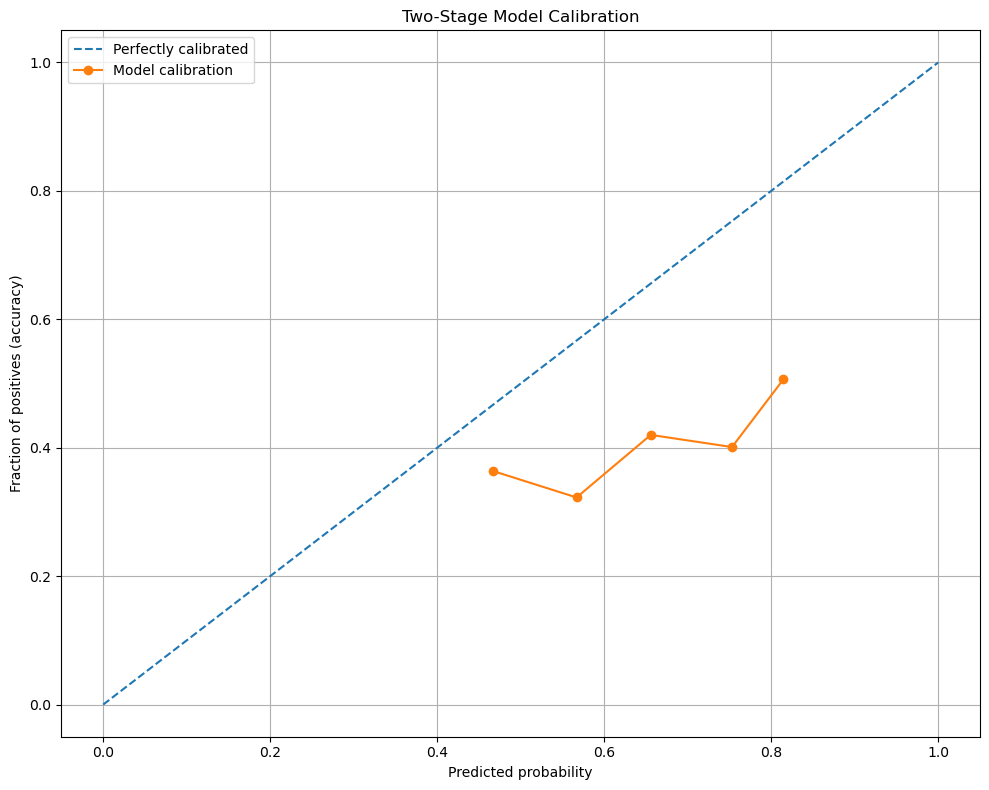

Mean calibration error: 0.2487

===== COMPARING TWO-STAGE ANALYZER WITH BASELINE =====
Baseline accuracy: 0.4585
Two-stage accuracy: 0.4183
Overall improvement: -4.01%

Improvement by sentiment class:
  Positive:
    Baseline: 0.6000
    Two-stage: 0.5250
    Improvement: -7.50%
    Sample size: 80 examples
  Neutral:
    Baseline: 0.2118
    Two-stage: 0.2059
    Improvement: -0.59%
    Sample size: 170 examples
  Negative:
    Baseline: 0.7677
    Two-stage: 0.6970
    Improvement: -7.07%
    Sample size: 99 examples


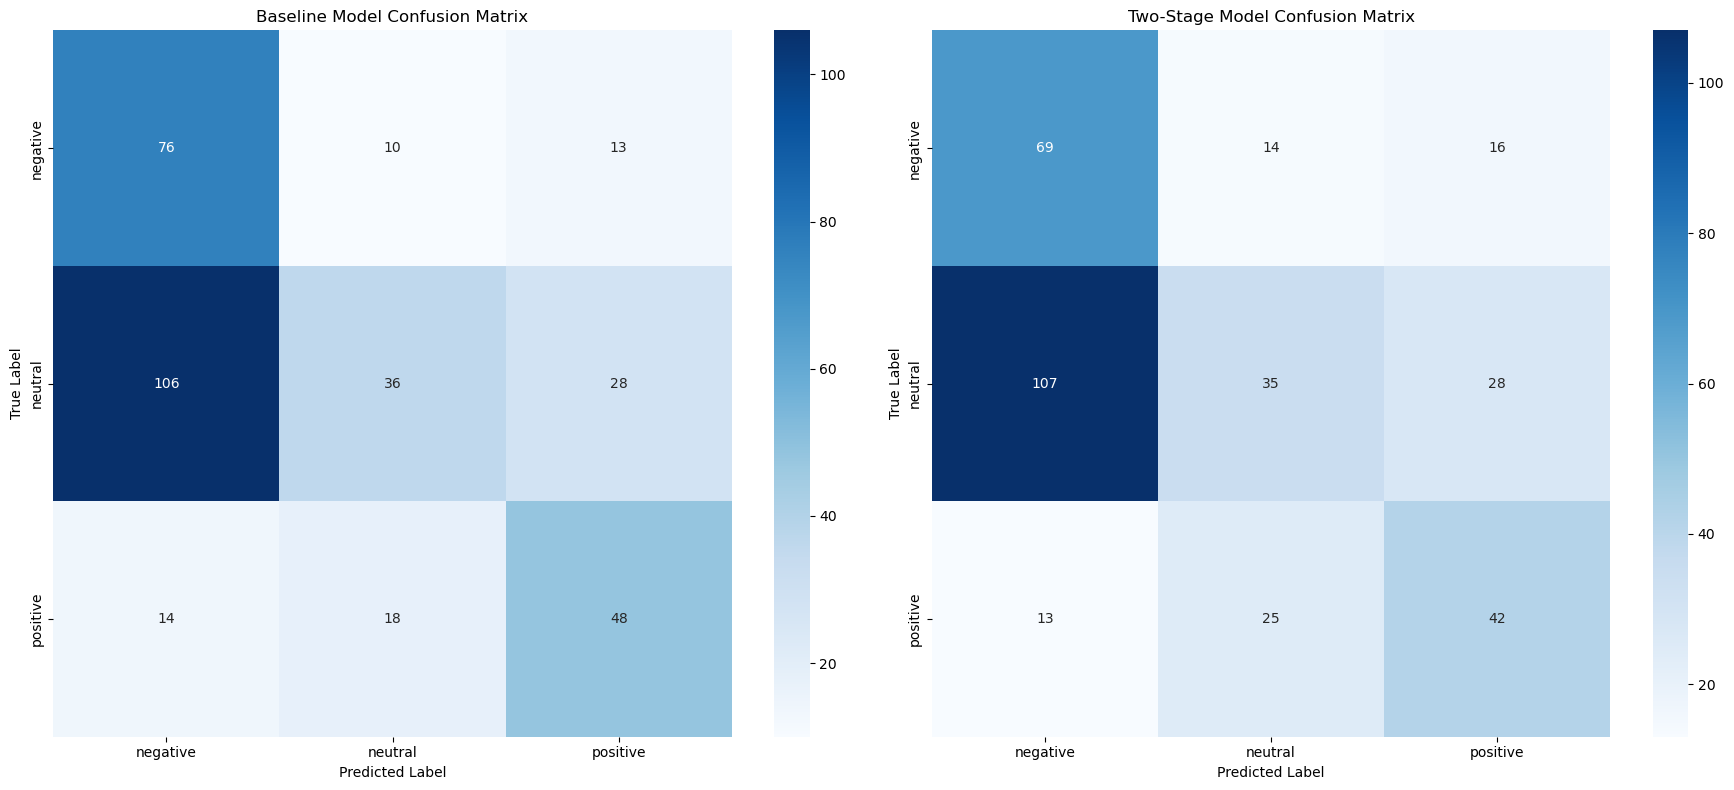

In [101]:
# -------- 7. EXECUTE THE ENHANCED ANALYSIS --------
def run_enhanced_sentiment_analysis(news_data=None, sample_size=None):
    """
    Run the enhanced sentiment analysis pipeline
    
    Args:
        news_data: DataFrame with financial news
        sample_size: Number of examples to analyze (None for all)
    
    Returns:
        Results from analysis
    """
    print("\n===== RUNNING ENHANCED SENTIMENT ANALYSIS =====")
    
    # Initialize analyzer
    analyzer = TwoStageFinancialSentimentAnalyzer(
        model_name="ProsusAI/finbert",
        temperature=2.0,
        neutral_threshold=0.7
    )
    
    # Run analysis
    two_stage_results = evaluate_two_stage_analyzer(
        news_data=news_data,
        analyzer=analyzer,
        sample_size=sample_size
    )
    
    # Create calibration plot
    print("\nCreating calibration plot...")
    calibration_error = create_calibration_plot(
        two_stage_results, 
        title="Two-Stage Model Calibration"
    )
    
    # Compare with baseline if available
    if 'original_results' in globals():
        comparison = compare_with_baseline(original_results, two_stage_results)
    
    return two_stage_results

# Run the enhanced analysis
enhanced_results = run_enhanced_sentiment_analysis(
    news_data=stock_news,
    sample_size=None  # Use None for full dataset, or a number for sample
)

## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [102]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

In [103]:
# Load the dataset
import pandas as pd

# Load the CSV
data = pd.read_csv("C:\\Users\\Nobody\\Downloads\\school stuff\\Stock Market News Sentiment Analysis and Summerization\\stock_news.csv")

# Convert 'Date' column to datetime format
data["Date"] = pd.to_datetime(data['Date'])





# Show shape of the data
print("Dataset loaded. Shape:", data.shape)

# Create a clean backup of the remapped dataset (restoration point)
stock_news_restorepoint = data.copy()
print("Restorepoint created. Shape:", stock_news_restorepoint.shape)

# Create a second backup just in case
stock_news_safepoint = data.copy()
print("Safepoint created. Shape:", stock_news_safepoint.shape)

# Preview
data.head()


Dataset loaded. Shape: (349, 8)
Restorepoint created. Shape: (349, 8)
Safepoint created. Shape: (349, 8)


,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


#### Loading the model

In [104]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama

# Download the GGUF model from Hugging Face
model_path = hf_hub_download(
    repo_id="TheBloke/Llama-2-7B-Chat-GGUF",
    filename="llama-2-7b-chat.Q4_K_M.gguf"
)

# Load the model
llm = Llama(model_path=model_path, n_ctx=2048)


llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from C:\Users\Nobody\.cache\huggingface\hub\models--TheBloke--Llama-2-7B-Chat-GGUF\snapshots\191239b3e26b2882fb562ffccdd1cf0f65402adb\llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 11008
llama_model_loader: - kv   6:                 llama.rope.di

#### Aggregating the data weekly

In [105]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [106]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [107]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [108]:
weekly_grouped

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,The U.S. stock market declined on Monday as c...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...
5,2019-02-10,"The Dow Jones Industrial Average, S&P 500, an..."
6,2019-02-17,"This week, the European Union's second highes..."
7,2019-02-24,This news article discusses progress towards ...
8,2019-03-03,The Dow Jones Industrial Average and other ma...
9,2019-03-10,"Spotify, the world's largest paid music strea..."


In [109]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

In [ ]:
#Note: Use this section to test out the prompt with one instance before using,
#it for the entire weekly data.

In [112]:
import json
import re
from tqdm import tqdm

# Max token limit for your model
max_tokens_limit = 2048

# Function to chunk large text into smaller pieces
def chunk_text(text, chunk_size):
    return [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]

# Simulated model response (replace with actual model API call)
def response_mistral_1(prompt, chunk):
    # Placeholder test output (simulate model response here)
    return '''
    {
      "Topic 1": {"Subject": "Federal Reserve", "Key events/actions": "Interest rate hike", "Keywords": "rate, inflation, policy"},
      "Topic 2": {"Subject": "Stock Market", "Key events/actions": "Dow drops", "Keywords": "Dow, decline, investor"}
    }
    '''

# Improved JSON extractor with error handling
def extract_json_data(response):
    try:
        match = re.search(r'\{[\s\S]*\}', response)
        if match:
            json_str = match.group()
            return json.loads(json_str)
        else:
            return {"error": "No JSON object found in response."}
    except Exception as e:
        return {"error": f"Failed to parse JSON: {str(e)}"}

# Store structured topic outputs
weekly_topics = []

# Iterate over each row in your data
for i, row in tqdm(data_1.iterrows(), total=len(data_1)):
    try:
        sample_news = row["News"][:max_tokens_limit]
        chunks = chunk_text(sample_news, max_tokens_limit)

        structured_data = []
        for chunk in chunks:
            prompt = """
            You are an expert data analyst specializing in news content analysis.

            Task: Analyze the provided news headline and return the main topics contained within it.

            Instructions:
            1. Read the news headline carefully.
            2. Identify the main subjects or entities mentioned in the headline.
            3. Determine the key events or actions described in the headline.
            4. Extract relevant keywords that represent the topics.
            5. Return the output in the following JSON format:

            {
              "Topic 1": {"Subject": "value", "Key events/actions": "value", "Keywords": "value"},
              "Topic 2": {"Subject": "value", "Key events/actions": "value", "Keywords": "value"}
            }
            """
            summary_json = response_mistral_1(prompt, chunk)
            structured_data.append(extract_json_data(summary_json))

        combined_data = {"Topics": structured_data}
    except Exception as e:
        combined_data = {"Error": str(e)}

    weekly_topics.append(combined_data)

# Add results to DataFrame
data_1["Weekly_Topics"] = weekly_topics
data_1["Weekly_Topics_Text"] = data_1["Weekly_Topics"].apply(
    lambda x: ' | '.join([f"{k}: {v}" for k, v in x.items()]) if isinstance(x, dict) else str(x)
)

# Preview
data_1[["Date", "Weekly_Topics_Text"]].head()


100%|██████████| 18/18 [00:00<00:00, 17928.63it/s]


,Date,Weekly_Topics_Text
0,2019-01-06,Topics: [{'Topic 1': {'Subject': 'Federal Rese...
1,2019-01-13,Topics: [{'Topic 1': {'Subject': 'Federal Rese...
2,2019-01-20,Topics: [{'Topic 1': {'Subject': 'Federal Rese...
3,2019-01-27,Topics: [{'Topic 1': {'Subject': 'Federal Rese...
4,2019-02-03,Topics: [{'Topic 1': {'Subject': 'Federal Rese...


##### Checking the model output on a sample

## **Conclusions and Recommendations**

In [148]:
"""

Conclusion and Recommendations:
This project has been an insightful and challenging journey into the realm of sentiment analysis,
specifically for stock market news. While the final accuracy of my model ,
may not have met my expectations, I gained invaluable experience in tackling real-world problems,
such as class imbalance and model fine-tuning. Throughout this project, I worked hard to apply,
different models, including BERT and FinBERT, to understand how sentiment in financial news ,
could be classified and analyzed.

One of the key challenges I faced was the class imbalance in the dataset, which significantly,
impacted the performance of my model. Despite my efforts to address this with techniques such as ,
SMOTE and undersampling, these strategies did not deliver the expected results.
As a result, the model struggled with the neutral sentiment class, 
leading to a disproportionate number of misclassifications.

To further improve the model, I explored a two-stage analyzer approach in an attempt to enhance,
performance. While this approach showed some promise, the results were not as successful as I had,
hoped. Specifically, I observed a drop in accuracy across all sentiment categories—especially,
positive and negative sentiments, which was disappointing considering the extensive work,
I put into refining these stages.

Additionally, one of the most difficult challenges I faced was integrating and fine-tuning ,
the LoRA (Low-Rank Adaptation) model. Although LoRA was expected to reduce the complexity ,
of the model while maintaining accuracy, the process of tuning and testing it was more complex ,
than anticipated. Despite the setbacks, I was able to get it working, but the model's accuracy ,
did not drastically improve.

From this project, I've learned that the nuances of financial sentiment analysis can be much more,
complex than expected, and that real-world datasets often require a lot of cleaning, adjustments, and experimentation before a robust solution is found. Though my model’s accuracy wasn't ideal, I’ve learned a great deal about fine-tuning, model selection, and the challenges that come with working with imbalanced datasets.
Looking ahead.
I would recommend several improvements for future iterations of this project:

Better Handling of Class Imbalance: Future efforts should focus more on sophisticated techniques,
for dealing with class imbalance, such as advanced oversampling or ,
cost-sensitive learning approaches, as SMOTE didn’t have the desired effect.

Model Refinement: I would look into incorporating other state-of-the-art models specifically ,
designed for financial sentiment analysis, such as FinBERT, but with a more robust fine-tuning,
process, potentially experimenting with different layers and learning rates.

Feature Engineering: I believe incorporating additional contextual financial features, 
such as company financial reports or stock trends, could improve the model’s predictive accuracy,
by providing richer information that may impact sentiment.

Evaluation Metrics: I’d also recommend using a broader set of evaluation metrics, 
such as precision, recall, and F1 score, in addition to accuracy. 
This would give a clearer picture of the model's performance, 
especially in dealing with neutral sentiment.

Data Augmentation: Exploring data augmentation techniques, such as creating synthetic news articles,
or leveraging other financial news sources, could help increase the diversity and ,
volume of training data, which may improve the model’s ability to generalize ,
across unseen examples.

Though the model did not yield the desired high accuracy, 
I’ve gained critical insight into the challenges and strategies involved in real-time ,
financial sentiment analysis. The lessons learned here will be invaluable as I continue to,
refine my skills and apply them to future projects, and I’m excited to keep experimenting with,
new approaches in the field of Natural Language Processing.


"""

"\n\nConclusion and Recommendations:\nThis project has been an insightful and challenging journey into the realm of sentiment analysis,\nspecifically for stock market news. While the final accuracy of my model ,\nmay not have met my expectations, I gained invaluable experience in tackling real-world problems,\nsuch as class imbalance and model fine-tuning. Throughout this project, I worked hard to apply,\ndifferent models, including BERT and FinBERT, to understand how sentiment in financial news ,\ncould be classified and analyzed.\n\nOne of the key challenges I faced was the class imbalance in the dataset, which significantly,\nimpacted the performance of my model. Despite my efforts to address this with techniques such as ,\nSMOTE and undersampling, these strategies did not deliver the expected results.\nAs a result, the model struggled with the neutral sentiment class, \nleading to a disproportionate number of misclassifications.\n\nTo further improve the model, I explored a two-sta

-




<font size=6 color='blue'>Power Ahead</font>
___